<a href="https://colab.research.google.com/github/pedro-otalora/oai-pmh2rdf/blob/main/TFG_PIPELINE_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CREACION DE UN DATASET RDF A PARTIR DEL REPOSITORIO OAI-PMH DE REVISTAS UM

VERSION 3


## 0. MONTAR DIRECTORIO DE ARCHIVOS

Monta la carpeta de Drive y establece la variable PIPELINE con el directorio de trabajo

In [ ]:
# importar libería drive
from google.colab import drive

# montar Google Drive en Colab
drive.mount('/content/drive')

# ruta de archivos del proyecto
PIPELINE = "/content/drive/MyDrive/4º GICD/TFG/PIPELINE/"
TABLAS = PIPELINE + "TABLAS/"
LOGS = PIPELINE + "LOGS/"
XML = PIPELINE + "XML/"
REVISION = PIPELINE + "REVISION/"
GRAFICOS = PIPELINE + "GRAFICOS/"
TESAUROS = PIPELINE + "TESAUROS/"
RDFOUT = PIPELINE + "RDFOUT/"



Mounted at /content/drive


# 1. EXTRACCIÓN DE DATOS

## 1.1 EXTRAER TABLA DE REVISTAS DESDE LA WEB

- Extrae la tabla de revistas mediante la lectura del código HTML.
- Desde la url principal se extrae el nombre y url de cada revista.
- Desde la url de cada revista se extraen los datos de DOI, ISSN e ISSN-E



In [ ]:
# EXTRAE LOS DATOS DE LA TABLA REVISTAS
# DESDE LA URL PRINCIPAL: NOMBRE Y URL DE CADA REVISTA
# DESDE LA URL DE CADA REVISTA: DOI, ISSN, ISSN-E

import os
import requests
from bs4 import BeautifulSoup
import csv
import time

# URL de la página web principal
URL = 'https://revistas.um.es/'

# Rutas de los archivos CSV y TXT
CSV_FILE = os.path.join(TABLAS, 'revistas.csv')
TXT_FILE = os.path.join(LOGS, 'extraccion_tabla_revistas.txt')

# Funciones de extracción y procesamiento
def extraer_datos_revista(li_element):
    """
    Extrae el nombre, URL, imagen, DOI, ISSN-E e ISSN-Impreso de un elemento <li> de revista.
    También genera el Revista_ID a partir de la URL.
    """
    try:
        # Extraer URL
        url = li_element.find('a', href=True)['href']

        # Extraer Revista_ID (parte final de la URL)
        revista_id = url.rstrip('/').split('/')[-1]

        # Extraer Nombre
        nombre = li_element.find('h3').text.strip()

        # Extraer URL de la imagen
        img_tag = li_element.find('img')
        imagen_url = img_tag['src'] if img_tag else None

        # Extraer datos adicionales (DOI, ISSN-E, ISSN-Impreso)
        datos_adicionales = extraer_datos_adicionales(url)

        return {
            'Revista_ID': revista_id,
            'Nombre': nombre,
            'URL': url,
            'Imagen': imagen_url,
            'DOI': datos_adicionales['DOI'],
            'ISSN-E': datos_adicionales['ISSN-E'],
            'ISSN-Impreso': datos_adicionales['ISSN-Impreso']
        }
    except Exception as e:
        print(f"Error al extraer datos de una revista: {e}")
        return None

def extraer_datos_adicionales(url):
    """
    Extrae DOI, ISSN-E e ISSN-Impreso de la URL de la revista.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extraer ISSN electrónico
        online_issn_container = soup.find('div', class_='online_issn_container')
        issn_e = online_issn_container.find('span', class_='number').text.strip() if online_issn_container else None

        # Extraer ISSN impreso
        print_issn_container = soup.find('div', class_='print_issn_container')
        issn_impreso = print_issn_container.find('span', class_='number').text.strip() if print_issn_container else None

        # Extraer DOI
        editum_doi_container = soup.find('div', class_='editum_doi')
        doi = editum_doi_container.find('span', class_='value').text.strip() if editum_doi_container else None

        return {'DOI': doi, 'ISSN-E': issn_e, 'ISSN-Impreso': issn_impreso}
    except requests.exceptions.RequestException as e:
        print(f"Error en la solicitud HTTP para {url}: {e}")
        return {'DOI': None, 'ISSN-E': None, 'ISSN-Impreso': None}
    except Exception as e:
        print(f"Error al analizar la página {url}: {e}")
        return {'DOI': None, 'ISSN-E': None, 'ISSN-Impreso': None}

def obtener_datos_web(url):
    """
    Obtiene todos los datos de las revistas desde la URL principal.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # Encontrar el contenedor de las revistas
        journals_div = soup.find('div', class_='journals')

        # Verificar si se encontró el contenedor
        if journals_div:
            # Encontrar todos los elementos <li> dentro del contenedor
            li_elements = journals_div.find_all('li', class_='has_thumb')

            # Extraer datos de cada revista
            datos = [extraer_datos_revista(li) for li in li_elements]

            # Filtrar los datos que son None (errores)
            datos = [dato for dato in datos if dato]

            return datos
        else:
            print("No se encontró el contenedor de revistas en la página.")
            return []
    except requests.exceptions.RequestException as e:
        print(f"Error en la solicitud HTTP: {e}")
        return []
    except Exception as e:
        print(f"Error al analizar la página: {e}")
        return []

# Guardar datos en CSV
def guardar_en_csv(datos, nombre_archivo):
    """
    Guarda los datos en un archivo CSV.
    """
    try:
        with open(nombre_archivo, 'w', newline='', encoding='utf-8') as csvfile:
            # Definir los nombres de las columnas
            fieldnames = ['Revista_ID', 'Nombre', 'URL', 'Imagen', 'DOI', 'ISSN-E', 'ISSN-Impreso']

            # Crear el escritor CSV
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            # Escribir la cabecera
            writer.writeheader()

            # Escribir los datos
            for dato in datos:
                writer.writerow(dato)
        print(f"Datos guardados en {nombre_archivo}")
    except Exception as e:
        print(f"Error al guardar en CSV: {e}")

# Generar y mostrar resumen
def generar_resumen(datos, tiempo_total):
    """
    Genera un resumen de los datos extraídos y lo muestra por pantalla.
    """
    total_revistas = len(datos)
    urls_con_imagen = sum(1 for dato in datos if dato['Imagen'])
    urls_sin_imagen = total_revistas - urls_con_imagen
    dois_encontrados = sum(1 for dato in datos if dato['DOI'])
    issn_e_encontrados = sum(1 for dato in datos if dato['ISSN-E'])
    issn_impreso_encontrados = sum(1 for dato in datos if dato['ISSN-Impreso'])

    resumen = f"Resumen de la extracción:\n"
    resumen += f"Total de revistas encontradas: {total_revistas}\n"
    resumen += f"Revistas con imagen: {urls_con_imagen}\n"
    resumen += f"Revistas sin imagen: {urls_sin_imagen}\n"
    resumen += f"DOIs encontrados: {dois_encontrados}\n"
    resumen += f"ISSN-E encontrados: {issn_e_encontrados}\n"
    resumen += f"ISSN-Impreso encontrados: {issn_impreso_encontrados}\n"
    resumen += f"Tiempo total de ejecución: {tiempo_total:.2f} segundos\n"

    print(resumen)  # Mostrar el resumen por pantalla
    return resumen

def guardar_resumen(resumen, nombre_archivo):
    """
    Guarda el resumen en un archivo.
    """
    try:
        with open(nombre_archivo, 'w', encoding='utf-8') as txtfile:
            txtfile.write(resumen)
        print(f"Resumen guardado en {nombre_archivo}")
    except Exception as e:
        print(f"Error al guardar el resumen: {e}")

# Ejecución principal
print("Iniciando la extracción de datos...")
tiempo_inicio = time.time()

datos = obtener_datos_web(URL)

if datos:
    guardar_en_csv(datos, CSV_FILE)
    tiempo_total = time.time() - tiempo_inicio
    resumen = generar_resumen(datos, tiempo_total)  # Genera y muestra el resumen
    guardar_resumen(resumen, TXT_FILE)
else:
    print("No se encontraron datos para guardar.")


Iniciando la extracción de datos...
Datos guardados en /content/drive/MyDrive/4º GICD/TFG/PIPELINE/TABLAS/revistas.csv
Resumen de la extracción:
Total de revistas encontradas: 43
Revistas con imagen: 43
Revistas sin imagen: 0
DOIs encontrados: 39
ISSN-E encontrados: 43
ISSN-Impreso encontrados: 26
Tiempo total de ejecución: 22.98 segundos

Resumen guardado en /content/drive/MyDrive/4º GICD/TFG/PIPELINE/LOGS/extraccion_tabla_revistas.txt


## 1.2 EXTRAER XML DE ARTICULOS DESDE OAI-PMH

En el repositorio tenemos varios formatos de metadatos. Una vez comprobada la calidad y completitud de cada uno de los formatos se decide el uso del formato oai_dc.

Se observa que el atributo lang de los metadatos no está consignado adecuadamente en todos los registros, por lo que deberá tenerse en cuenta más adelante.

Se añade control de errores para que no detenga la extracción si se producen errores.

In [ ]:
# EXTRAE LOS REGISTROS OAI-PMH EN FORMATO XML
# LAS URL BASE PARA LA EXTRACCIÓN LAS COGE DE LA TABLA DE REVISTAS
# SE OMITEN LOS REGISTROS CON ESTADO "DELETED"

import os
import requests
import csv
import time
import xml.etree.ElementTree as ET
from datetime import datetime

# Archivos de entrada y salida
CSV_FILE = os.path.join(TABLAS, 'revistas.csv')
TXT_FILE = os.path.join(LOGS, 'extraccion_xml_articulos_oai_dc.txt')
XML_FILE = os.path.join(XML, 'articulos_oai_dc.xml')

def extract_raw_oai_pmh_to_xml(base_url, xml_file):
    """
    Extrae todos los registros OAI-PMH en formato oai_dc de una URL base y los guarda directamente en el archivo XML,
    excluyendo los registros eliminados.
    """
    url = f"{base_url}/oai?verb=ListRecords&metadataPrefix=oai_dc"
    record_count = 0
    error_count = 0
    deleted_count = 0
    max_retries = 3
    retry_count = 0

    while True:
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            root = ET.fromstring(response.content)
            retry_count = 0  # Reiniciar contador si tiene éxito
        except (requests.exceptions.RequestException, ET.ParseError) as e:
            print(f"Error al obtener o analizar la respuesta XML: {e}")
            retry_count += 1
            if retry_count >= max_retries:
                print(f"Máximo número de reintentos alcanzado para {url}. Pasando al siguiente conjunto.")
                break
            print(f"Reintentando... (intento {retry_count} de {max_retries})")
            time.sleep(5)
            continue

        # Buscar todos los registros en el XML
        records = root.findall('.//{http://www.openarchives.org/OAI/2.0/}record')

        for record in records:
            # Verificar si el registro está marcado como eliminado
            header = record.find('.//{http://www.openarchives.org/OAI/2.0/}header')
            if header is not None and header.get('status') == 'deleted':
                deleted_count += 1
                continue  # Saltar este registro

            record_count += 1
            try:
                with open(xml_file, 'a', encoding='utf-8') as file:
                    file.write(ET.tostring(record, encoding='unicode'))
            except Exception as e:
                error_count += 1
                print(f"Error al guardar el registro {record_count}: {e}")

        # Buscar el resumptionToken para continuar con la paginación
        resumption_token = root.find('.//{http://www.openarchives.org/OAI/2.0/}resumptionToken')
        if resumption_token is None or not resumption_token.text:
            break

        url = f"{base_url}/oai?verb=ListRecords&resumptionToken={resumption_token.text}"
        time.sleep(1)  # Pausa para no saturar el servidor

    return record_count, error_count, deleted_count


def process_revistas_from_csv(csv_file):
    """
    Procesa las URLs de revistas desde un archivo CSV y guarda los registros directamente en un archivo XML.
    """
    total_record_count = 0
    total_error_count = 0
    total_deleted_count = 0
    revista_count = 0
    resumen_extraccion = ""
    start_time = datetime.now()

    # Crear el archivo XML con la cabecera inicial
    with open(XML_FILE, 'w', encoding='utf-8') as file:
        file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        file.write('<OAI-PMH>\n')

    try:
        with open(csv_file, 'r', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                revista_count += 1
                revista_url = row['URL']
                nombre_revista = revista_url.split('/')[-1]
                # print(f"Procesando revista {revista_count}: {nombre_revista} - {revista_url}")
                resumen_extraccion += f"Procesando revista {revista_count}: {nombre_revista} - {revista_url}\n"

                try:
                    record_count, error_count, deleted_count = extract_raw_oai_pmh_to_xml(revista_url, XML_FILE)
                    total_record_count += record_count
                    total_error_count += error_count
                    total_deleted_count += deleted_count

                    # print(f"  Total de registros extraídos: {record_count}")
                    # print(f"  Registros con errores: {error_count}")
                    # print(f"  Registros eliminados omitidos: {deleted_count}")
                    resumen_extraccion += f"  Total de registros extraídos: {record_count}\n"
                    resumen_extraccion += f"  Registros con errores: {error_count}\n"
                    resumen_extraccion += f"  Registros eliminados omitidos: {deleted_count}\n"

                except Exception as e:
                    print(f"Error al procesar la revista {nombre_revista}: {e}")
                    resumen_extraccion += f"Error al procesar la revista {nombre_revista}: {e}\n"
                # print("---")
                resumen_extraccion += "---\n"

    except FileNotFoundError:
        print(f"Error: El archivo {csv_file} no se encuentra.")
        return

    # Cerrar la etiqueta raíz del archivo XML al final del proceso
    with open(XML_FILE, 'a', encoding='utf-8') as file:
        file.write('</OAI-PMH>\n')

    end_time = datetime.now()
    duration = end_time - start_time

    # Imprimir y guardar el resumen final
    resumen_final = f"\nResumen final:\n"
    resumen_final += f"Total de revistas procesadas: {revista_count}\n"
    resumen_final += f"Total de registros extraídos: {total_record_count}\n"
    resumen_final += f"Total de registros con errores: {total_error_count}\n"
    resumen_final += f"Total de registros eliminados omitidos: {total_deleted_count}\n"
    resumen_final += f"Tiempo total de ejecución: {duration}\n"

    print(resumen_final)
    resumen_extraccion += resumen_final

    try:
        with open(TXT_FILE, 'w', encoding='utf-8') as txtfile:
            txtfile.write(resumen_extraccion)
        print(f"Resumen guardado en {TXT_FILE}")
    except Exception as e:
        print(f"Error al guardar el resumen: {e}")


# Ejecución del script
print("Iniciando la extracción de datos de las revistas desde el CSV...")
process_revistas_from_csv(CSV_FILE)


Iniciando la extracción de datos de las revistas desde el CSV...
Procesando revista 1: analesbio - https://revistas.um.es/analesbio
  Total de registros extraídos: 651
  Registros con errores: 0
  Registros eliminados omitidos: 7
---
Procesando revista 2: analesderecho - https://revistas.um.es/analesderecho
  Total de registros extraídos: 565
  Registros con errores: 0
  Registros eliminados omitidos: 0
---
Procesando revista 3: analesdoc - https://revistas.um.es/analesdoc
  Total de registros extraídos: 511
  Registros con errores: 0
  Registros eliminados omitidos: 1
---
Procesando revista 4: analesff - https://revistas.um.es/analesff
  Total de registros extraídos: 709
  Registros con errores: 0
  Registros eliminados omitidos: 2
---
Procesando revista 5: analesps - https://revistas.um.es/analesps
  Total de registros extraídos: 1765
  Registros con errores: 0
  Registros eliminados omitidos: 1
---
Procesando revista 6: analesvet - https://revistas.um.es/analesvet
  Total de registr

## 1.3 EXTRAER TABLA ARTICULOS-HTML

En los metadatos oai-pmh de los registros no hay ningún identificador con el que se pueda relacionar de manera unívoca, necesario para la creación de la tabla NUMEROS.

En este caso particular se extrae el número desde el código html de cada artículo de la web. Se aprovecha la lectura para enriquecer los artículos con el DOI y la cita bibliográfica completa presente en cada página web de artículo.

Se añade una función de reanudar si se queda a medio y hay que volveer a ejecutarlo

**REVISAR COLUMNAS nombre_volumen y revista_volumen (repetidas)**



In [ ]:
import os
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
from datetime import datetime
import xml.etree.ElementTree as ET
import re

# Archivos de entrada y salida
INPUT_XML = os.path.join(XML, 'articulos_oai_dc.xml')
REVISTAS_CSV = os.path.join(TABLAS, 'revistas.csv')
OUTPUT_CSV = os.path.join(TABLAS, 'articulos_html.csv')
SUMMARY_TXT = os.path.join(LOGS, 'extraccion_tabla_articulos_html.txt')

# Espacios de nombres del XML
namespaces = {
    'dc': "http://purl.org/dc/elements/1.1/",
    'ns0': "http://www.openarchives.org/OAI/2.0/",
    'ns1': "http://www.openarchives.org/OAI/2.0/oai_dc/"
}

def extract_doi(soup):
    """
    Extrae el DOI desde el HTML.
    """
    doi_section = soup.find('section', class_='item doi')
    if doi_section:
        doi_link = doi_section.find('a')
        if doi_link:
            return doi_link['href'].strip()

    # Si no se encuentra, buscar usando el patrón DOI en el texto
    doi_pattern = re.compile(r'https://doi\.org/\S+')
    doi_match = soup.find(string=doi_pattern)
    return doi_match.strip() if doi_match else ''

def extract_citation(soup):
    """
    Extrae la cita desde el HTML.
    """
    citation_div = soup.find('div', class_='csl-entry')
    if citation_div:
        citation = citation_div.text.strip()
        # Eliminar "Cómo citar" y "Descargar cita" si están presentes
        citation = re.sub(r'(Cómo citar|Descargar cita).*', '', citation, flags=re.DOTALL)
        return citation.strip()
    return ''

def extraer_info(url):
    """
    Extrae el volumen, la URL del volumen, DOI y cita desde el HTML de la página web.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extraer volumen y URL del volumen
        item_issue = soup.find('div', class_='item issue')
        volumen = None
        volumen_url = None
        if item_issue:
            link = item_issue.find('a', class_='title')
            if link:
                volumen = link.text.strip()
                volumen_url = link['href']

        # Extraer DOI y cita
        doi = extract_doi(soup)
        cita = extract_citation(soup)

        return volumen, volumen_url, doi, cita
    except Exception as e:
        print(f"Error al extraer información de la URL {url}: {e}")
        return None, None, None, None

def process_record(record, revistas_dict):
    """
    Procesa un registro individual del XML para extraer:
    - Identificador ns0 (de <ns0:identifier>).
    - Identificador principal (URL priorizada que comienza con https://revistas.um.es/).
    - Revista_ID (extraído desde revistas.csv).
    - Volumen, volumen_url, DOI y cita (extraídos del HTML).
    - Nombre + Volumen.
    - Revista_volumen (nombre de la revista y volumen concatenados).
    """
    # Extraer identificador principal desde <ns0:identifier>
    ns0_identifier_element = record.find('.//ns0:identifier', namespaces)
    ns0_identifier = ns0_identifier_element.text.strip() if ns0_identifier_element is not None else None

    # Extraer identificador principal y priorizar URLs que comiencen con https://revistas.um.es/
    identifiers = record.findall('.//dc:identifier', namespaces)
    identifier = None
    for identifier_element in identifiers:
        identifier_text = identifier_element.text.strip() if identifier_element.text else ''
        if identifier_text.startswith("https://revistas.um.es/"):
            identifier = identifier_text
            break

    # Si no hay URL válida (identifier), retornamos solo el ns0_identifier
    if not identifier:
        return {'ns0_identifier': ns0_identifier}

    # Extraer Revista_ID desde revistas.csv utilizando la URL base
    revista_id = None
    nombre_revista = None
    for base_url, data in revistas_dict.items():
        if base_url in identifier:
            revista_id, nombre_revista = data
            break

    # Si no se encuentra Revista_ID en revistas.csv, retornamos solo el ns0_identifier e identifier
    if not revista_id:
        return {'ns0_identifier': ns0_identifier, 'identifier': identifier}

    # Extraer volumen, volumen_url, DOI y cita desde el HTML de la URL principal
    volumen, volumen_url, doi, cita = extraer_info(identifier)

    # Crear nombre_volumen concatenando nombre_revista y volumen
    nombre_volumen = f"{nombre_revista} {volumen}" if nombre_revista and volumen else None

    # Crear revista_volumen concatenando nombre_revista y volumen
    revista_volumen = f"{nombre_revista} {volumen}" if nombre_revista and volumen else None

    # Retornar los datos procesados
    return {
        'ns0_identifier': ns0_identifier,
        'identifier': identifier,
        'Revista_ID': revista_id,
        'nombre_volumen': nombre_volumen,
        'revista_volumen': revista_volumen,
        'volumen': volumen,
        'volumen_url': volumen_url,
        'doi': doi,
        'cita': cita,
    }

# Iniciar el tiempo de ejecución
start_time = datetime.now()

# Leer el archivo XML y revistas.csv
try:
    tree = ET.parse(INPUT_XML)
    root = tree.getroot()

    # Leer revistas.csv y construir un diccionario {URL base: (Revista_ID, Nombre)}
    revistas_df = pd.read_csv(REVISTAS_CSV)
    revistas_dict = dict(zip(revistas_df['URL'], zip(revistas_df['Revista_ID'], revistas_df['Nombre'])))
except Exception as e:
    print(f"Error al leer los archivos: {e}")
    exit()

# Definir los campos del CSV
fieldnames = ['ns0_identifier', 'identifier', 'Revista_ID', 'nombre_volumen', 'revista_volumen',
              'volumen', 'volumen_url', 'doi', 'cita']

# Verificar si el archivo de salida ya existe
if os.path.exists(OUTPUT_CSV):
    # Si existe, leer el último registro procesado
    with open(OUTPUT_CSV, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        processed_records = [row['ns0_identifier'] for row in reader]
    print(f"Reanudando desde el registro {len(processed_records) + 1}")
    mode = 'a'
else:
    processed_records = []
    mode = 'w'

# Abrir el archivo CSV en modo append si ya existe, o write si es nuevo
with open(OUTPUT_CSV, mode=mode, encoding='utf-8', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Escribir la cabecera si es un archivo nuevo
    if mode == 'w':
        writer.writeheader()

    # Contadores para el resumen final
    total_records = len(processed_records)
    total_volumes_found = 0
    total_dois_found = 0
    total_citations_found = 0
    total_errors = 0

    # Procesar cada registro en el XML
    print("Iniciando el procesamiento de registros...\n")
    for i, record in enumerate(root.findall('.//ns0:record', namespaces), start=1):
        ns0_identifier_element = record.find('.//ns0:identifier', namespaces)
        ns0_identifier = ns0_identifier_element.text.strip() if ns0_identifier_element is not None else None

        # Saltar registros ya procesados
        if ns0_identifier in processed_records:
            continue

        try:
            processed_data = process_record(record, revistas_dict)
            writer.writerow(processed_data)
            total_records += 1

            # Actualizar contadores
            if processed_data.get('volumen'):
                total_volumes_found += 1
            if processed_data.get('doi'):
                total_dois_found += 1
            if processed_data.get('cita'):
                total_citations_found += 1

        except Exception as e:
            print(f"Error al procesar un registro: {e}")
            # Escribir el registro con error, incluyendo solo el identificador
            writer.writerow({'ns0_identifier': ns0_identifier})
            total_errors += 1

        # Informar del progreso cada 1000 registros procesados
        if total_records % 1000 == 0:
            print(f"Procesados {total_records} registros...")

print("\nProcesamiento completado.\n")

# Calcular el tiempo total de ejecución
end_time = datetime.now()
duration = end_time - start_time

# Generar resumen de resultados
resumen = f"""
Resumen de extracción de revistas y volúmenes:
----------------------------------------------
Total de registros procesados: {total_records}
Total de volúmenes encontrados: {total_volumes_found}
Total de DOIs encontrados: {total_dois_found}
Total de citas encontradas: {total_citations_found}
Total de errores durante la extracción: {total_errors}
Tiempo total de ejecución: {duration}

El archivo CSV se ha guardado en:
'{OUTPUT_CSV}'
"""

print(resumen)

# Guardar resumen en un archivo TXT
with open(SUMMARY_TXT, 'w', encoding='utf-8') as summary_file:
    summary_file.write(resumen)

print(f"Resumen guardado en '{SUMMARY_TXT}'")


Reanudando desde el registro 10879
Iniciando el procesamiento de registros...

Procesados 10880 registros...
Procesados 10890 registros...
Procesados 10900 registros...
Procesados 10910 registros...
Procesados 10920 registros...
Procesados 10930 registros...
Procesados 10940 registros...
Procesados 10950 registros...
Procesados 10960 registros...
Procesados 10970 registros...
Procesados 10980 registros...
Procesados 10990 registros...
Procesados 11000 registros...
Procesados 11010 registros...
Procesados 11020 registros...
Procesados 11030 registros...
Procesados 11040 registros...
Procesados 11050 registros...
Procesados 11060 registros...
Procesados 11070 registros...
Procesados 11080 registros...
Procesados 11090 registros...
Procesados 11100 registros...
Procesados 11110 registros...
Procesados 11120 registros...
Procesados 11130 registros...
Procesados 11140 registros...
Procesados 11150 registros...
Procesados 11160 registros...
Procesados 11170 registros...
Procesados 11180 regi

## 1.4 EXTRACCIÓN TABLA NÚMEROS

Para realizar esta tabla se parte de los valores únicos de la tabla articulos_html y se realiza una lectura del html para extraer datos DOI e imagen

**REVISAR COLUMNAS nombre_volumen y revista_volumen (repetidas)**

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
from datetime import datetime
from collections import Counter

# Archivos de entrada y salida
INPUT_CSV = os.path.join(TABLAS, 'articulos_html.csv')
OUTPUT_CSV = os.path.join(TABLAS, 'numeros.csv')
SUMMARY_TXT = os.path.join(LOGS, 'extraccion_tabla_numeros.txt')

def extraer_imagen_url(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        img_tags = soup.find_all('img')
        for img in img_tags:
            if 'cover' in img.get('src', '').lower() or 'cover' in img.get('alt', '').lower():
                return img['src']
        return None
    except Exception as e:
        print(f"Error procesando {url}: {str(e)}")
        return None

# Iniciar el tiempo de ejecución
start_time = datetime.now()

# Cargar el DataFrame original
df = pd.read_csv(INPUT_CSV)

# Eliminar filas donde revista_volumen está vacío o nulo
df_filtered = df.dropna(subset=['revista_volumen']).reset_index(drop=True)

# Seleccionar las columnas requeridas y obtener valores únicos
df_unique = df_filtered[['Revista_ID', 'nombre_volumen', 'revista_volumen', 'volumen', 'volumen_url']].drop_duplicates(subset='revista_volumen').reset_index(drop=True)



# Añadir nueva columna para la imagen
df_unique['imagen_numero'] = ''

# Contadores para el resumen
total_numeros = len(df_unique)
imagenes_encontradas = 0

# Procesar cada fila para extraer la URL de la imagen
for index, row in df_unique.iterrows():
    # print(f"\nProcesando registro {index + 1} de {total_numeros}")
    # print(f"URL: {row['volumen_url']}")

    imagen_url = extraer_imagen_url(row['volumen_url'])

    if imagen_url:
        df_unique.at[index, 'imagen_numero'] = imagen_url
        # print(f"Imagen URL encontrada: {imagen_url}")
        imagenes_encontradas += 1
    else:
        # print("No se encontró URL de imagen")

# Guardar el DataFrame final
df_unique.to_csv(OUTPUT_CSV, index=False)

# Calcular estadísticas para el resumen
numeros_por_revista = Counter(df_unique['Revista_ID'])
numeros_con_imagen = df_unique['imagen_numero'].notna().sum()
numeros_sin_imagen = total_numeros - numeros_con_imagen

# Calcular el tiempo total de ejecución
end_time = datetime.now()
duration = end_time - start_time

# Generar resumen de resultados
resumen = f"""
Resumen de extracción de imágenes de números de revista:
--------------------------------------------------------
Total de números distintos: {total_numeros}
Cantidad de imágenes extraídas: {imagenes_encontradas}
Números con imagen: {numeros_con_imagen}
Números sin imagen: {numeros_sin_imagen}

Números por revista:
"""

for revista_id, count in numeros_por_revista.items():
    resumen += f"  Revista ID {revista_id}: {count} números\n"

resumen += f"""
Tiempo total de ejecución: {duration}

El archivo CSV se ha guardado en:
'{OUTPUT_CSV}'
"""

print(resumen)

# Guardar resumen en un archivo TXT
with open(SUMMARY_TXT, 'w', encoding='utf-8') as summary_file:
    summary_file.write(resumen)

print(f"Resumen guardado en '{SUMMARY_TXT}'")


Se han truncado las últimas 5000 líneas del flujo de salida.

Procesando registro 364 de 1598
URL: https://revistas.um.es/areas/issue/view/10831
Imagen URL encontrada: https://revistas.um.es/public/journals/221/cover_issue_10831_es_ES.jpg

Procesando registro 365 de 1598
URL: https://revistas.um.es/areas/issue/view/12651
Imagen URL encontrada: https://revistas.um.es/public/journals/221/cover_issue_12651_es_ES.jpg

Procesando registro 366 de 1598
URL: https://revistas.um.es/areas/issue/view/13281
Imagen URL encontrada: https://revistas.um.es/public/journals/221/cover_issue_13281_es_ES.jpg

Procesando registro 367 de 1598
URL: https://revistas.um.es/areas/issue/view/14461
Imagen URL encontrada: https://revistas.um.es/public/journals/221/cover_issue_14461_es_ES.jpg

Procesando registro 368 de 1598
URL: https://revistas.um.es/areas/issue/view/15191
Imagen URL encontrada: https://revistas.um.es/public/journals/221/cover_issue_15191_es_ES.jpg

Procesando registro 369 de 1598
URL: https://rev

# 2 CREACIÓN DE TABLAS


## 2.1 CREACIÓN DE TABLA ARTÍCULOS


In [ ]:
# VERSION 0

# SE PROCESAN LOS METADATOS SELECCIONADOS
# SE AÑADE EL NOMBRE, URL Y REVISTA_ID DE LA REVISTA DESDE LA TABLA REVISTAS
# EN LOS METADATOS CON ATRIBUTO DE IDIOMA SE PRIORIZA EL CASTELLANO, DESPUES LO QUE NO TENGAN, Y LUEGO EL INGLES, Y DESPÚES EL INGLES O CUALQUIER OTRO
import os
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
import re
import html

# Rutas de archivos
INPUT_XML = os.path.join(XML, 'articulos_oai_dc.xml')
OUTPUT_CSV = os.path.join(TABLAS, 'articulos.csv')
SUMMARY_TXT = os.path.join(LOGS, 'creacion_tabla_articulos.txt')
REVISTAS_CSV = os.path.join(TABLAS, 'revistas.csv')

# Definir espacios de nombres
namespaces = {
    'dc': "http://purl.org/dc/elements/1.1/",
    'ns0': "http://www.openarchives.org/OAI/2.0/",
    'ns1': "http://www.openarchives.org/OAI/2.0/oai_dc/"
}

# Función de limpieza
def limpiar_texto(texto):
    # Decodificar entidades HTML
    texto = html.unescape(texto)
    # Eliminar etiquetas HTML
    texto = re.sub('<[^<]+?>', '', texto)
    # Reemplazar saltos de línea por espacios
    texto = re.sub(r'\n|\r', ' ', texto)
    # Eliminar códigos HTML específicos (como &acute;, &quot;, etc.)
    texto = re.sub(r'&[a-zA-Z]+;', '', texto)
    # Eliminar espacios en blanco al inicio y al final
    texto = texto.strip()
    # Reemplazar múltiples espacios en blanco por uno solo
    texto = re.sub(r'\s+', ' ', texto)
    return texto

def get_title(record):
    """Extrae el valor del título (<dc:title>) con prioridad y aplica limpieza"""
    titles = record.findall(".//dc:title", namespaces)
    es_titles = []
    no_lang_titles = []
    other_titles = []

    for title in titles:
        lang = title.get('{http://www.w3.org/XML/1998/namespace}lang')
        text = limpiar_texto(title.text) if title.text else ''

        if lang == 'es-ES':
            es_titles.append(text)
        elif lang is None:
            no_lang_titles.append(text)
        else:
            other_titles.append((lang, text))

    if es_titles:
        return es_titles[0], 'es-ES'
    elif no_lang_titles:
        return no_lang_titles[0], 'sin_atributo'
    elif other_titles:
        return other_titles[0][1], 'otros'
    else:
        return '', 'vacío'

def get_all_values(record, tag):
    """Extrae todos los valores de un metadato específico con prioridad y aplica limpieza"""
    values = record.findall(f".//dc:{tag}", namespaces)
    es_values = []
    no_lang_values = []
    other_values = []

    for v in values:
        lang = v.get('{http://www.w3.org/XML/1998/namespace}lang')
        text = limpiar_texto(v.text) if v.text else ''

        if lang == 'es-ES':
            es_values.append(text)
        elif lang is None:
            no_lang_values.append(text)
        else:
            other_values.append((lang, text))

    if es_values:
        return ' | '.join(es_values)
    elif no_lang_values:
        return ' | '.join(no_lang_values)
    elif other_values:
        return ' | '.join([val[1] for val in other_values])
    else:
        return ''

def get_setSpec(record):
    """Extrae el valor del metadato <ns0:setSpec>."""
    setSpec_element = record.find('.//ns0:setSpec', namespaces)
    if setSpec_element is not None:
        return setSpec_element.text
    return None

def process_xml_to_csv(input_xml, output_csv, revistas_csv):
    """Convierte un archivo XML a un archivo CSV."""
    start_time = datetime.now()
    total_records = 0
    error_count = 0
    resumen_extraccion = ""
    total_caracteres_originales = 0
    total_caracteres_limpios = 0

    # Contadores para los idiomas de los títulos
    title_counts = {'es-ES': 0, 'sin_atributo': 0, 'otros': 0, 'vacío': 0}

    # Leer el archivo de revistas
    revistas_df = pd.read_csv(revistas_csv)
    revistas_dict = dict(zip(revistas_df['URL'], zip(revistas_df['Nombre'], revistas_df['Revista_ID'])))

    try:
        tree = ET.parse(input_xml)
        root = tree.getroot()

        data = []

        for record in root.findall('.//ns0:record', namespaces):
            try:
                header = record.find('.//ns0:header', namespaces)

                if header is not None and header.get('status') == 'deleted':
                    continue

                record_data = {}

                # Extraer el identificador del registro
                identifier = record.find('.//ns0:identifier', namespaces)
                record_data['ns0_identifier'] = identifier.text if identifier is not None else ''

                # Extraer el título con prioridad por idioma
                title_text, title_lang = get_title(record)
                record_data['title'] = title_text

                # Actualizar contadores de idiomas de títulos
                if title_lang in title_counts:
                    title_counts[title_lang] += 1

                # Extraer otros campos del registro con la misma lógica que el título
                for tag in ['creator', 'subject', 'description', 'publisher',
                            'date', 'type', 'format', 'identifier', 'source',
                            'language', 'relation', 'rights', 'date']:
                    value = get_all_values(record, tag)
                    record_data[tag] = value
                    total_caracteres_originales += len(value)
                    total_caracteres_limpios += len(limpiar_texto(value))

                # Determinar la revista, URL y Revista_ID basado en el metadato <ns0:setSpec>
                setSpec = get_setSpec(record)
                if setSpec:
                    revista_alias = setSpec.split(':')[0]
                    revista_url = next((url for url in revistas_dict.keys() if revista_alias in url), None)

                    if revista_url:
                        record_data['Revista'] = revistas_dict[revista_url][0]
                        record_data['url'] = revista_url
                        record_data['Revista_ID'] = revistas_dict[revista_url][1]
                    else:
                        record_data['Revista'] = 'Desconocida'
                        record_data['url'] = ''
                        record_data['Revista_ID'] = ''
                else:
                    record_data['Revista'] = 'Desconocida'
                    record_data['url'] = ''
                    record_data['Revista_ID'] = ''

                data.append(record_data)
                total_records += 1

            except Exception as e:
                error_count += 1
                print(f"Error al procesar un registro: {e}")
                resumen_extraccion += f"Error al procesar un registro: {e}\n"

        # Convertir los datos a un DataFrame de pandas y guardar como CSV
        df = pd.DataFrame(data)
        # Reordenar las columnas
        columns_order = ['Revista', 'Revista_ID', 'url', 'ns0_identifier'] + [col for col in df.columns if col not in ['Revista', 'Revista_ID', 'url', 'ns0_identifier']]
        df = df[columns_order]
        df.to_csv(output_csv, index=False, sep=',', encoding='utf-8')

        print(f"Archivo CSV guardado en: {output_csv}")
        resumen_extraccion += f"Archivo CSV guardado en: {output_csv}\n"

    except Exception as e:
        print(f"Error al procesar el archivo XML: {e}")
        resumen_extraccion += f"Error al procesar el archivo XML: {e}\n"

    end_time = datetime.now()
    duration = end_time - start_time

    # Guardar el resumen en un archivo de texto
    resumen_final = f"\nResumen final:\n"
    resumen_final += f"Total de registros procesados: {total_records}\n"
    resumen_final += f"Total de errores: {error_count}\n"
    resumen_final += f"Títulos en español (es-ES): {title_counts['es-ES']}\n"
    resumen_final += f"Títulos sin atributo de idioma: {title_counts['sin_atributo']}\n"
    resumen_final += f"Títulos en otros idiomas: {title_counts['otros']}\n"
    resumen_final += f"Títulos vacíos: {title_counts['vacío']}\n"
    resumen_final += f"Total de caracteres originales: {total_caracteres_originales}\n"
    resumen_final += f"Total de caracteres después de la limpieza: {total_caracteres_limpios}\n"
    resumen_final += f"Reducción de caracteres: {total_caracteres_originales - total_caracteres_limpios} ({((total_caracteres_originales - total_caracteres_limpios) / total_caracteres_originales * 100):.2f}%)\n"
    resumen_final += f"Tiempo total de ejecución: {duration}\n"

    print(resumen_final)
    resumen_extraccion += resumen_final

    with open(SUMMARY_TXT, 'w', encoding='utf-8') as txtfile:
        txtfile.write(resumen_extraccion)

# Ejecutar la conversión XML a CSV
print("Iniciando la conversión del archivo XML a CSV...")
process_xml_to_csv(INPUT_XML, OUTPUT_CSV, REVISTAS_CSV)


Iniciando la conversión del archivo XML a CSV...
Archivo CSV guardado en: /content/drive/MyDrive/4º GICD/TFG/PIPELINE/TABLAS/articulos.csv

Resumen final:
Total de registros procesados: 24577
Total de errores: 0
Títulos en español (es-ES): 23484
Títulos sin atributo de idioma: 0
Títulos en otros idiomas: 1093
Títulos vacíos: 0
Total de caracteres originales: 30986894
Total de caracteres después de la limpieza: 30986247
Reducción de caracteres: 647 (0.00%)
Tiempo total de ejecución: 0:00:19.989949



## 2.2 CREACIÓN DE TABLA AUTORES

In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.1 MB/s eta 0:00:00


In [ ]:
# SE CREA LA TABLA AUTORES DESDE EL XML DE ARTICULOS
# SE CREA UNA TABLA DE AUTORES CON INCIDNECIAS QUE INCLUYE AUTORES QUE COMIENZAN CON CARACTERES NO ALFABÉTICOS
# SE CREA UNA TABLA DE AUTORES SIMILARES USANDO RAPIZFUZZ CON UNA COINCIDENCIA DEL 90%
# AL IMPLEMENTAR UNA REVISIÓN POSTERIOR, LAS TABLAS INCIDENCIAS Y SIMILARES DEJAN DE TENER USO
# SE PUEDE REALIZAR UNA VERSIÓN QUE ELIMINE ESTAS FUNCIONES

import os
import re
import pandas as pd
from collections import defaultdict
from datetime import datetime
from rapidfuzz import fuzz
import xml.etree.ElementTree as ET
import html

# Archivos de entrada y salida
INPUT_XML = os.path.join(XML, 'articulos_oai_dc.xml')
OUTPUT_AUTORES_CSV = os.path.join(TABLAS, 'autores.csv')
OUTPUT_AUTORES_INCIDENCIAS_CSV = os.path.join(REVISION, 'autores_incidencias.csv')
OUTPUT_AUTORES_SIMILARES_CSV = os.path.join(REVISION, 'autores_similares.csv')
SUMMARY_TXT = os.path.join(LOGS, 'creacion_tabla_autores.txt')

# Espacios de nombres del XML
namespaces = {
    'dc': "http://purl.org/dc/elements/1.1/",
    'ns0': "http://www.openarchives.org/OAI/2.0/",
    'ns1': "http://www.openarchives.org/OAI/2.0/oai_dc/"
}

# Función de limpieza
def limpiar_texto(texto):
    # Decodificar entidades HTML
    texto = html.unescape(texto)
    # Eliminar etiquetas HTML
    texto = re.sub('<[^<]+?>', '', texto)
    # Reemplazar saltos de línea por espacios
    texto = re.sub(r'\n|\r', ' ', texto)
    # Eliminar códigos HTML específicos (como &acute;, &quot;, etc.)
    texto = re.sub(r'&[a-zA-Z]+;', '', texto)
    # Eliminar espacios en blanco al inicio y al final
    texto = texto.strip()
    # Reemplazar múltiples espacios en blanco por uno solo
    texto = re.sub(r'\s+', ' ', texto)
    return texto

def find_similar_authors(authors, threshold=98):
    """Encuentra autores similares utilizando RapidFuzz."""
    similar_authors = []
    authors = sorted(authors, key=len)
    for i, author1 in enumerate(authors):
        for author2 in authors[i+1:]:
            if abs(len(author1) - len(author2)) > 3:
                break
            similarity = fuzz.ratio(author1, author2)
            if similarity >= threshold:
                similar_authors.append((author1, author2))
    return similar_authors

def is_valid_author(author):
    """Comprueba si el autor comienza con un carácter alfabético o vocal acentuada."""
    return bool(re.match(r'^[a-zA-ZÁÉÍÓÚáéíóú]', author))

# Iniciar el tiempo de ejecución
start_time = datetime.now()

# Leer el archivo XML
try:
    tree = ET.parse(INPUT_XML)
    root = tree.getroot()
except Exception as e:
    print(f"Error al leer el archivo XML: {e}")
    exit()

# Crear un diccionario para almacenar los autores y sus identificadores
author_dict = defaultdict(list)

# Listas para almacenar incidencias
blank_authors = []
invalid_authors = []

# Contadores de limpieza
total_caracteres_originales = 0
total_caracteres_limpios = 0

# Procesar cada registro en el XML
for record in root.findall('.//ns0:record', namespaces):
    try:
        # Extraer identificador del registro
        identifier_element = record.find('.//ns0:identifier', namespaces)
        identifier = identifier_element.text if identifier_element is not None else ''

        # Extraer autores desde <dc:creator>
        creators = record.findall('.//dc:creator', namespaces)
        for creator_element in creators:
            original_text = creator_element.text.strip() if creator_element.text else ''
            cleaned_text = limpiar_texto(original_text)  # Aplicar limpieza

            total_caracteres_originales += len(original_text)
            total_caracteres_limpios += len(cleaned_text)

            if cleaned_text:
                if not is_valid_author(cleaned_text):
                    invalid_authors.append((cleaned_text, identifier))
                author_dict[cleaned_text].append(identifier)
            else:
                blank_authors.append(('', identifier))
    except Exception as e:
        print(f"Error al procesar un registro: {e}")

# Crear un DataFrame con los autores y sus identificadores
author_data = {
    'author': [],
    'ns0_identifiers': [],
    'count': []
}

for author, ids in author_dict.items():
    author_data['author'].append(author)
    author_data['ns0_identifiers'].append(' | '.join(ids))
    author_data['count'].append(len(ids))

result_df = pd.DataFrame(author_data)

# Ordenar alfabéticamente por autor
result_df = result_df.sort_values('author')

# Guardar el resultado en un nuevo CSV
result_df.to_csv(OUTPUT_AUTORES_CSV, index=False, encoding='utf-8')

print(f"Tabla de autores guardada en '{OUTPUT_AUTORES_CSV}'")

# Crear y guardar tabla de incidencias
incidencias_df = pd.DataFrame(blank_authors + invalid_authors, columns=['author', 'ns0_identifier'])
incidencias_df.to_csv(OUTPUT_AUTORES_INCIDENCIAS_CSV, index=False, encoding='utf-8')

print(f"Tabla de autores con incidencias guardada en '{OUTPUT_AUTORES_INCIDENCIAS_CSV}'")

# Encontrar autores similares
authors_list = result_df['author'].tolist()
similar_authors = find_similar_authors(authors_list)

# Crear y guardar tabla de autores similares
similares_df = pd.DataFrame(similar_authors, columns=['author1', 'author2'])
similares_df.to_csv(OUTPUT_AUTORES_SIMILARES_CSV, index=False, encoding='utf-8')

print(f"Tabla de autores similares guardada en '{OUTPUT_AUTORES_SIMILARES_CSV}'")

# Generar resumen de resultados
total_authors = len(result_df)
total_records = len(root.findall('.//ns0:record', namespaces))
most_prolific_author = result_df.loc[result_df['count'].idxmax()]['author']
most_prolific_count = result_df.loc[result_df['count'].idxmax()]['count']

# Calcular el tiempo total de ejecución
end_time = datetime.now()
duration = end_time - start_time

resumen = f"""
Resumen de extracción y limpieza de autores:
--------------------------------------------
Total de registros procesados: {total_records}
Total de autores únicos: {total_authors}
Autor con más artículos asociados: {most_prolific_author} ({most_prolific_count} artículos)
Tiempo total de ejecución: {duration}

Limpieza aplicada:
------------------
Total caracteres originales: {total_caracteres_originales}
Total caracteres después de la limpieza: {total_caracteres_limpios}
Reducción de caracteres: {total_caracteres_originales - total_caracteres_limpios} ({((total_caracteres_originales - total_caracteres_limpios) / total_caracteres_originales * 100):.2f}%)

Incidencias detectadas:
-----------------------
Autores en blanco: {len(blank_authors)}
Autores que comienzan con caracteres no alfabéticos (excepto vocales acentuadas): {len(invalid_authors)}
Autores potencialmente similares: {len(similar_authors)}

Detalles de las incidencias se han guardado en:
'{OUTPUT_AUTORES_INCIDENCIAS_CSV}'
'{OUTPUT_AUTORES_SIMILARES_CSV}'
"""

print(resumen)

# Guardar resumen en un archivo TXT
with open(SUMMARY_TXT, 'w', encoding='utf-8') as summary_file:
    summary_file.write(resumen)

print(f"Resumen guardado en '{SUMMARY_TXT}'")


Tabla de autores guardada en '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/TABLAS/autores.csv'
Tabla de autores con incidencias guardada en '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/REVISION/autores_incidencias.csv'
Tabla de autores similares guardada en '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/REVISION/autores_similares.csv'

Resumen de extracción y limpieza de autores:
--------------------------------------------
Total de registros procesados: 24577
Total de autores únicos: 34945
Autor con más artículos asociados: Autores, Varios (110 artículos)
Tiempo total de ejecución: 0:01:41.264746

Limpieza aplicada:
------------------
Total caracteres originales: 1042584
Total caracteres después de la limpieza: 1042437
Reducción de caracteres: 147 (0.01%)

Incidencias detectadas:
-----------------------
Autores en blanco: 27
Autores que comienzan con caracteres no alfabéticos (excepto vocales acentuadas): 43
Autores potencialmente similares: 80

Detalles de las incidencias se han guardad

## 2.3 CREACIÓN DE LA TABLA DE PALABRAS CLAVE

In [ ]:
# LA NORNALIZACIÓN DE PALABRAS CLAVE NO SE HA LLEGADO A IMPLEMENTAR
# LAS TABLAS INCIDENCIAS Y SIMILARES NO SE HAN UTILIZADO FINALMENTE
# SE PUEDE REALIZAR UNA NUEVA VERSIÓN QUE NO GENERE DICHAS TABLAS

import os
import re
import pandas as pd
from collections import defaultdict
from datetime import datetime
from rapidfuzz import fuzz
import xml.etree.ElementTree as ET
import html

# Archivos de entrada y salida
INPUT_XML = os.path.join(XML, 'articulos_oai_dc.xml')
OUTPUT_KEYWORDS_CSV = os.path.join(TABLAS, 'keywords_es.csv')
OUTPUT_KEYWORDS_INCIDENCIAS_CSV = os.path.join(REVISION, 'keywords_incidencias_es.csv')
OUTPUT_KEYWORDS_SIMILARES_CSV = os.path.join(REVISION, 'keywords_similares_es.csv')
SUMMARY_TXT = os.path.join(LOGS, 'creacion_tabla_keywords_es.txt')

# Espacios de nombres del XML
namespaces = {
    'dc': "http://purl.org/dc/elements/1.1/",
    'ns0': "http://www.openarchives.org/OAI/2.0/",
    'ns1': "http://www.openarchives.org/OAI/2.0/oai_dc/"
}

# Función de limpieza
def limpiar_texto(texto):
    """
    Limpia un texto eliminando:
    - Entidades HTML.
    - Etiquetas HTML.
    - Saltos de línea.
    - Códigos HTML (&acute;, &quot;, etc.).
    - Comillas simples, dobles, españolas (« ») y rectas.
    - Paréntesis, corchetes y otros símbolos no propios de una palabra clave.
    - Espacios múltiples.
    """
    # Decodificar entidades HTML
    texto = html.unescape(texto)
    # Eliminar etiquetas HTML
    texto = re.sub('<[^<]+?>', '', texto)
    # Reemplazar saltos de línea por espacios
    texto = re.sub(r'\n|\r', ' ', texto)
    # Eliminar códigos HTML específicos (como &acute;, &quot;, etc.)
    texto = re.sub(r'&[a-zA-Z]+;', '', texto)
    # Eliminar comillas simples, dobles, españolas y rectas
    texto = re.sub(r'[\'\"«»“”‘’]', '', texto)
    # Eliminar paréntesis, corchetes y otros símbolos no deseados
    texto = re.sub(r'[\(\)\[\]\{\}<>]', '', texto)
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar espacios en blanco al inicio y al final
    texto = texto.strip()
    # Reemplazar múltiples espacios en blanco por uno solo
    texto = re.sub(r'\s+', ' ', texto)
    return texto

def find_similar_keywords(keywords, threshold=98):
    """Encuentra palabras clave similares utilizando RapidFuzz."""
    similar_keywords = []
    keywords = sorted(keywords, key=len)
    for i, keyword1 in enumerate(keywords):
        for keyword2 in keywords[i+1:]:
            if abs(len(keyword1) - len(keyword2)) > 3:
                break
            similarity = fuzz.ratio(keyword1, keyword2)
            if similarity >= threshold:
                similar_keywords.append((keyword1, keyword2))
    return similar_keywords

def is_valid_keyword(keyword):
    """Comprueba si la palabra clave comienza con un carácter alfabético o vocal acentuada."""
    return bool(re.match(r'^[a-zA-ZáéíóúÁÉÍÓÚ]', keyword))

def process_record(record):
    """Procesa un registro individual del XML."""
    identifier_element = record.find('.//ns0:identifier', namespaces)
    identifier = identifier_element.text if identifier_element is not None else ''

    keywords = record.findall('.//dc:subject', namespaces)

    for keyword_element in keywords:
        raw_keyword = keyword_element.text.strip() if keyword_element.text else ''
        lang = keyword_element.get('{http://www.w3.org/XML/1998/namespace}lang')  # Obtener el atributo xml:lang

        # Procesar solo palabras clave en español (es-ES)
        if lang == 'es-ES':
            if raw_keyword:
                # Separar las palabras clave por ';' o ','
                separated_keywords = [limpiar_texto(k) for k in re.split(r'[;,]', raw_keyword)]

                for cleaned_keyword in separated_keywords:
                    if cleaned_keyword:
                        if is_valid_keyword(cleaned_keyword):
                            # Unificar las palabras clave en el diccionario acumulando identificadores
                            keyword_dict[cleaned_keyword].extend([identifier])
                        else:
                            invalid_keywords.append((cleaned_keyword, identifier))
                    else:
                        blank_keywords.append(('', identifier))

# Iniciar el tiempo de ejecución
start_time = datetime.now()

# Leer el archivo XML
try:
    tree = ET.parse(INPUT_XML)
    root = tree.getroot()
except Exception as e:
    print(f"Error al leer el archivo XML: {e}")
    exit()

# Crear un diccionario para almacenar las palabras clave y sus identificadores
keyword_dict = defaultdict(list)

# Listas para almacenar incidencias
blank_keywords = []
invalid_keywords = []

# Procesar cada registro en el XML
for record in root.findall('.//ns0:record', namespaces):
    process_record(record)

# Crear un DataFrame con las palabras clave y sus identificadores (unificados)
keyword_data = {
    'keyword': [],
    'ns0_identifiers': [],
    'count': []
}

for keyword, ids in keyword_dict.items():
    unique_ids = list(set(ids))  # Eliminar duplicados en los identificadores asociados a cada palabra clave
    keyword_data['keyword'].append(keyword)
    keyword_data['ns0_identifiers'].append(' | '.join(unique_ids))
    keyword_data['count'].append(len(unique_ids))  # Contar ocurrencias únicas

result_df = pd.DataFrame(keyword_data)

# Ordenar alfabéticamente por palabra clave
result_df = result_df.sort_values('keyword')

# Guardar el resultado en un nuevo CSV
result_df.to_csv(OUTPUT_KEYWORDS_CSV, index=False, encoding='utf-8')

print(f"Tabla de palabras clave guardada en '{OUTPUT_KEYWORDS_CSV}'")

# Crear y guardar tabla de incidencias
incidencias_df = pd.DataFrame(blank_keywords + invalid_keywords, columns=['keyword', 'ns0_identifier'])
incidencias_df.to_csv(OUTPUT_KEYWORDS_INCIDENCIAS_CSV, index=False, encoding='utf-8')

print(f"Tabla de palabras clave con incidencias guardada en '{OUTPUT_KEYWORDS_INCIDENCIAS_CSV}'")

# Encontrar palabras clave similares (basado solo en las palabras clave válidas)
keywords_list = result_df['keyword'].tolist()
similar_keywords = find_similar_keywords(keywords_list)

# Crear y guardar tabla de palabras clave similares
similares_df = pd.DataFrame(similar_keywords, columns=['keyword1', 'keyword2'])
similares_df.to_csv(OUTPUT_KEYWORDS_SIMILARES_CSV, index=False, encoding='utf-8')

print(f"Tabla de palabras clave similares guardada en '{OUTPUT_KEYWORDS_SIMILARES_CSV}'")

# Generar resumen de resultados
total_keywords = len(result_df)
total_records = len(root.findall('.//ns0:record', namespaces))
most_common_keyword = result_df.loc[result_df['count'].idxmax()]['keyword']
most_common_count = result_df.loc[result_df['count'].idxmax()]['count']

# Calcular el tiempo total de ejecución
end_time = datetime.now()
duration = end_time - start_time

resumen = f"""
Resumen de extracción y limpieza de palabras clave (es-ES):
-----------------------------------------------------------
Total de registros procesados: {total_records}
Total de palabras clave únicas: {total_keywords}
Palabra clave más común: {most_common_keyword} ({most_common_count} apariciones)
Tiempo total de ejecución: {duration}

Incidencias detectadas:
-----------------------
Palabras clave en blanco: {len(blank_keywords)}
Palabras clave inválidas: {len(invalid_keywords)}
Palabras clave potencialmente similares: {len(similar_keywords)}

Detalles de las incidencias se han guardado en:
'{OUTPUT_KEYWORDS_INCIDENCIAS_CSV}'
'{OUTPUT_KEYWORDS_SIMILARES_CSV}'
"""

print(resumen)

# Guardar resumen en un archivo TXT
with open(SUMMARY_TXT, 'w', encoding='utf-8') as summary_file:
    summary_file.write(resumen)

print(f"Resumen guardado en '{SUMMARY_TXT}'")


Tabla de palabras clave guardada en '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/TABLAS/keywords_es.csv'
Tabla de palabras clave con incidencias guardada en '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/REVISION/keywords_incidencias_es.csv'
Tabla de palabras clave similares guardada en '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/REVISION/keywords_similares_es.csv'

Resumen de extracción y limpieza de palabras clave (es-ES):
-----------------------------------------------------------
Total de registros procesados: 24577
Total de palabras clave únicas: 39719
Palabra clave más común: enfermería (385 apariciones)
Tiempo total de ejecución: 0:01:41.298819

Incidencias detectadas:
-----------------------
Palabras clave en blanco: 59
Palabras clave inválidas: 117
Palabras clave potencialmente similares: 177

Detalles de las incidencias se han guardado en:
'/content/drive/MyDrive/4º GICD/TFG/PIPELINE/REVISION/keywords_incidencias_es.csv'
'/content/drive/MyDrive/4º GICD/TFG/PIPELINE/REVISION/ke

## 2.4 CREACIÓN DE LA TABLA CORPUS

- MINÚSCULAS
- Limpieza básica de caracteres no válidos, números y signos de puntuación
- ELIMINACION DE PALABRAS VACÍAS
- LEMATIZACION

In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import re
import pandas as pd
from datetime import datetime
import xml.etree.ElementTree as ET
import html
import nltk
from nltk.corpus import stopwords
import spacy

# Descargamos la lista de stop words
nltk.download('stopwords', quiet=True)

# Archivos de entrada y salida
INPUT_XML = os.path.join(XML, 'articulos_oai_dc.xml')
OUTPUT_CORPUS_LIMPIO_CSV = os.path.join(TABLAS, 'corpus_es.csv')
SUMMARY_TXT = os.path.join(LOGS, 'creacion_tabla_corpus.txt')

# Espacios de nombres del XML
namespaces = {
    'dc': "http://purl.org/dc/elements/1.1/",
    'ns0': "http://www.openarchives.org/OAI/2.0/",
    'ns1': "http://www.openarchives.org/OAI/2.0/oai_dc/"
}

# Inicializar spaCy para lematización en español
nlp = spacy.load('es_core_news_lg')

# Categorías gramaticales permitidas para lematización
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

# Obtener stopwords
stop_words = set(stopwords.words('spanish') + stopwords.words('english') + stopwords.words('french') + stopwords.words('portuguese'))

def limpiar_texto(texto):
    # Decodificar entidades HTML
    texto = html.unescape(texto)
    # Eliminar etiquetas HTML
    texto = re.sub('<[^<]+?>', '', texto)
    # Reemplazar saltos de línea por espacios
    texto = re.sub(r'\n|\r', ' ', texto)
    # Eliminar códigos HTML específicos
    texto = re.sub(r'&[a-zA-Z]+;', '', texto)
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar números y caracteres especiales, excepto letras y espacios
    texto = re.sub(r'[^a-záéíóúñ]', ' ', texto)
    # Reemplazar múltiples espacios por uno solo
    texto = re.sub(r'\s+', ' ', texto)
    # Eliminar espacios al principio y al final
    return texto.strip()

def procesar_texto(texto):
    if not isinstance(texto, str):
        return "", 0, 0

    texto_limpio = limpiar_texto(texto)
    palabras_antes = texto_limpio.split()
    total_palabras_antes = len(palabras_antes)

    doc = nlp(texto_limpio)

    palabras_procesadas = [token.lemma_ for token in doc if not token.is_stop and not token.is_oov and len(token.text) > 2 and token.pos_ in allowed_postags]

    total_palabras_despues = len(palabras_procesadas)
    palabras_eliminadas = total_palabras_antes - total_palabras_despues

    return " ".join(palabras_procesadas), total_palabras_antes, palabras_eliminadas

def process_record(record):
    identifier_element = record.find('.//ns0:identifier', namespaces)
    identifier = identifier_element.text if identifier_element is not None else ''

    corpus = []
    for tag in ['title', 'description', 'subject']:
        elements = record.findall(f'.//dc:{tag}', namespaces)
        for element in elements:
            lang = element.get('{http://www.w3.org/XML/1998/namespace}lang')
            if lang == 'es-ES' or lang is None:
                if element.text:
                    corpus.append(element.text)
                break

    return identifier, ' '.join(corpus)

# Iniciar el tiempo de ejecución
start_time = datetime.now()

# Leer el archivo XML
try:
    tree = ET.parse(INPUT_XML)
    root = tree.getroot()
except Exception as e:
    print(f"Error al leer el archivo XML: {e}")
    exit()

# Procesar cada registro en el XML
corpus_data = []
total_caracteres_originales = 0
total_etiquetas_html_eliminadas = 0
total_saltos_linea_eliminados = 0

for record in root.findall('.//ns0:record', namespaces):
    identifier, corpus = process_record(record)

    caracteres_originales = sum(len(element.text or '') for element in record.findall('.//dc:*', namespaces))
    total_caracteres_originales += caracteres_originales

    etiquetas_html = len(re.findall(r'<[^<]+?>', ''.join(element.text or '' for element in record.findall('.//dc:*', namespaces))))
    total_etiquetas_html_eliminadas += etiquetas_html

    saltos_linea = len(re.findall(r'\n|\r', ''.join(element.text or '' for element in record.findall('.//dc:*', namespaces))))
    total_saltos_linea_eliminados += saltos_linea

    corpus_data.append({'ns_identifier': identifier, 'Corpus': corpus})

# Crear un DataFrame con los datos extraídos
df = pd.DataFrame(corpus_data)

# Aplicar procesamiento de texto
df[['Corpus', 'total_palabras_antes', 'palabras_eliminadas']] = df['Corpus'].apply(lambda x: pd.Series(procesar_texto(x)))

# Calcular estadísticas finales
total_terminos = len(df)
total_palabras_antes = df['total_palabras_antes'].sum()
total_palabras_eliminadas = df['palabras_eliminadas'].sum()
total_palabras_despues = total_palabras_antes - total_palabras_eliminadas
longitudes = df['Corpus'].apply(lambda x: len(x.split()))
longitud_promedio = longitudes.mean()
termino_mas_largo = df.loc[longitudes.idxmax(), 'Corpus']
termino_mas_corto = df.loc[longitudes.idxmin(), 'Corpus']

# Guardar el DataFrame limpio final
df.to_csv(OUTPUT_CORPUS_LIMPIO_CSV, index=False)

# Calcular el tiempo total de ejecución
end_time = datetime.now()
duration = end_time - start_time

# Generar resumen de resultados
resumen = f"""
Resumen de extracción, limpieza y lematización del corpus:
----------------------------------------------------------
Total de registros procesados: {total_terminos}
Total de caracteres originales: {total_caracteres_originales}
Total de etiquetas HTML eliminadas: {total_etiquetas_html_eliminadas}
Total de saltos de línea eliminados: {total_saltos_linea_eliminados}
Total de palabras antes del procesamiento: {total_palabras_antes}
Total de palabras eliminadas: {total_palabras_eliminadas}
Total de palabras después del procesamiento: {total_palabras_despues}
Reducción de palabras: {((total_palabras_antes - total_palabras_despues) / total_palabras_antes * 100):.2f}%
Longitud promedio de los términos finales (en palabras): {longitud_promedio:.2f}
Término más largo (en palabras): "{termino_mas_largo}" ({len(termino_mas_largo.split())} palabras)
Término más corto (en palabras): "{termino_mas_corto}" ({len(termino_mas_corto.split())} palabras)
Total de stopwords utilizadas: {len(stop_words)}
Tiempo total de ejecución: {duration}

El archivo CSV con el corpus limpio final se ha guardado en:
'{OUTPUT_CORPUS_LIMPIO_CSV}'
"""

print(resumen)

# Guardar resumen en un archivo TXT
with open(SUMMARY_TXT, 'w', encoding='utf-8') as summary_file:
    summary_file.write(resumen)

print(f"Resumen guardado en '{SUMMARY_TXT}'")



Resumen de extracción, limpieza y lematización del corpus:
----------------------------------------------------------
Total de registros procesados: 24577
Total de caracteres originales: 54554492
Total de etiquetas HTML eliminadas: 14
Total de saltos de línea eliminados: 9891
Total de palabras antes del procesamiento: 3027663
Total de palabras eliminadas: 1756008
Total de palabras después del procesamiento: 1271655
Reducción de palabras: 58.00%
Longitud promedio de los términos finales (en palabras): 51.96
Término más largo (en palabras): "consideración paradigma formación médico formación medico enfrentar reto formación profesional ejercicio salud especialmente disciplina medicina punto partida problemática comenzar curso inicio pregrado medicina evidenciar él dificultad acceso educación médico puesto promedio anualmente presentar cerca aspirante cerca cupo disponible facultad medicina país posibilidad acceso lograr estudiante medicina sumado anteriormente descrito conflicto financie

# 3. REVISIÓN NORMALIZACION AUTORES

Se realizan agrupaciones de autores similares con variantes de espacios, tildes, mayúsculas, puntos o guiones.
Se guarda la variante del autor con más ocurrencias.

In [ ]:
import pandas as pd
import re
import unicodedata
from google.colab import files

# Rutas de archivos
INPUT_CSV = os.path.join(TABLAS, "autores.csv")
OUTPUT_CSV = os.path.join(TABLAS, "autores_normalizados.csv")
SUMMARY_TXT = os.path.join(LOGS, 'autores_normalizados.txt')



def normalizar_formato(autor):
    # Normalizar variaciones mínimas conservando tildes y mayúsculas
    autor = unicodedata.normalize('NFD', autor)
    autor = ''.join([c for c in autor if not unicodedata.combining(c)])  # Eliminar diacríticos para comparación

    # Manejar variaciones de puntuación y espacios
    autor = re.sub(r'(\b\w+)-(\w+\b)(?=,)', r'\1 \2', autor)  # Apellidos compuestos
    autor = re.sub(r'(?<=, )(\w+)-(\w+)', r'\1 \2', autor)  # Nombres compuestos
    autor = re.sub(r'\s*,\s*', ', ', autor)  # Espacios alrededor de comas
    autor = re.sub(r'\s+', ' ', autor).lower().strip()  # Minúsculas solo para comparación

    # Unificar formato de iniciales
    autor = re.sub(r'\b([a-z])\.\s+([a-z])\.?', r'\1.\2', autor)

    return autor

def detectar_variantes(df):
    grupos = {}
    for idx, row in df.iterrows():
        base = normalizar_formato(row['Autor'])
        if base not in grupos:
            grupos[base] = []
        grupos[base].append(idx)
    return {k:v for k,v in grupos.items() if len(v)>1}

def procesar_normalizacion():
    # uploaded = files.upload()
    # filename = next(iter(uploaded))
    # df = pd.read_csv('autores.csv', header=None, names=['Autor', 'Articulos', 'Apariciones'])
    df = pd.read_csv(INPUT_CSV, header=None, names=['Autor', 'Articulos', 'Apariciones'])

    # Convertir columna numérica
    df['Apariciones'] = pd.to_numeric(df['Apariciones'], errors='coerce').fillna(0).astype(int)

    grupos = detectar_variantes(df)
    cambios = []
    reporte = []

    for nombre_base, indices in grupos.items():
        variantes = df.loc[indices, 'Autor'].tolist()
        articulos = list(set('|'.join(df.loc[indices, 'Articulos']).split('|')))
        total_apariciones = df.loc[indices, 'Apariciones'].sum()

        # Seleccionar variante canónica (la más completa)
        # variante_principal = max(variantes, key=lambda x: len(x))

        # Seleccionar variante canónica (la que más apariciones tiene)
        variante_principal = max(variantes, key=lambda x: df[df['Autor'] == x]['count'].sum())

        cambios.append({
            'Base': nombre_base,
            'Variantes': variantes,
            'Principal': variante_principal,
            'Fusionados': len(indices),
            'Articulos': len(articulos),
            'Apariciones': total_apariciones
        })

        # Actualizar dataframe
        df.loc[indices[0]] = [variante_principal, ' | '.join(articulos), total_apariciones]
        df = df.drop(indices[1:])

    # Construir reporte
    reporte.append("═" * 50)
    reporte.append(f"Autores originales: {len(df) + sum(len(g) for g in grupos.values())}")
    reporte.append(f"Autores finales: {len(df)}")
    reporte.append(f"Grupos fusionados: {len(grupos)}\n")
    print(reporte)

    for cambio in cambios:
        reporte.append(f"Grupo: {cambio['Base']}")
        reporte.append(f"└→ Variante principal: {cambio['Principal']}")
        reporte.append(f"   ├─ Variantes detectadas ({cambio['Fusionados']}):")
        for v in cambio['Variantes']:
            reporte.append(f"   │  • {v}")
        reporte.append(f"   ├─ Artículos consolidados: {cambio['Articulos']}")
        reporte.append(f"   └─ Apariciones totales: {cambio['Apariciones']}\n")

    # Mostrar y guardar reporte
    reporte_final = '\n'.join(reporte)
    # print(reporte_final)

    # with open('log.txt', 'w', encoding='utf-8') as f:
    with open(SUMMARY_TXT, 'w', encoding='utf-8') as f:
        f.write(reporte_final)

    # Guardar resultados
    df.to_csv(OUTPUT_CSV, index=False, header=False)
    # df.to_csv('autores_normalizados.csv', index=False, header=False)
    # files.download('autores_normalizados.csv')
    # files.download('log.txt')

print("=== NORMALIZACIÓN SEMIAUTOMÁTICA CONSERVATIVA ===")
procesar_normalizacion()


Se han truncado las últimas 5000 líneas del flujo de salida.
└→ Variante principal: Morales Morgado, Erla
   ├─ Variantes detectadas (2):
   │  • Morales Morgado, Erla
   │  • Morales-Morgado, Erla
   ├─ Artículos consolidados: 2
   └─ Apariciones totales: 2

Grupo: morales nieto, arelia
└→ Variante principal: Morales Nieto, Arelia
   ├─ Variantes detectadas (2):
   │  • Morales Nieto, Arelia
   │  • Morales-Nieto, Arelia
   ├─ Artículos consolidados: 3
   └─ Apariciones totales: 3

Grupo: morales rodriguez, francisco manuel
└→ Variante principal: Morales Rodríguez, Francisco Manuel
   ├─ Variantes detectadas (2):
   │  • Morales Rodríguez, Francisco Manuel
   │  • Morales-Rodríguez, Francisco Manuel
   ├─ Artículos consolidados: 2
   └─ Apariciones totales: 2

Grupo: morales sanchez, veronica
└→ Variante principal: Morales Sanchez, Veronica
   ├─ Variantes detectadas (3):
   │  • Morales Sanchez, Veronica
   │  • Morales Sánchez, Verónica
   │  • Morales-Sánchez, Verónica
   ├─ Artícu

# 4. ENRIQUECIMIENTO CON FUENTES EXTERNAS

## 4.1 RECONCILIACIÓN DE KEYWORDS CON TESAURO UNESCO

In [ ]:
!pip install sparqlwrapper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
"""
# --------------------------------------------
# VERSION DE CONSULTA EN EL PUNTO SPARQL
# TIEMPO APROX. 4 HORAS PARA 40.000 TÉRMINOS
# SE PREFIERE LA VERSION EN LOCAL
# ---------------------------------------------

from SPARQLWrapper import SPARQLWrapper, JSON

# Configurar el endpoint SPARQL del Tesauro de la UNESCO
sparql = SPARQLWrapper("https://vocabularies.unesco.org/sparql")

# Función para buscar términos en el tesauro de la UNESCO
def buscar_termino(termino):
    query = f"""
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT ?concept ?label ?lang
    WHERE {{
        ?concept skos:prefLabel ?label .
        FILTER (lang(?label) IN ('es', 'en'))
        FILTER (lcase(str(?label)) = '{termino.lower()}')
        BIND(lang(?label) AS ?lang)
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        return [(result["concept"]["value"], result["label"]["value"], result["lang"]["value"])
                for result in results["results"]["bindings"]]
    except Exception as e:
        print(f"Error al buscar el término '{termino}': {str(e)}")
        return []

Se crea una versión para consultar el rdf descargado

In [ ]:
# VERSION OFFLINE


import os
import pandas as pd
from rdflib import Graph, URIRef, Literal
from rdflib.namespace import SKOS
import re
import csv
from datetime import datetime

# Archivos de entrada y salida
INPUT_CSV = os.path.join(TABLAS, 'keywords_es.csv')
OUTPUT_CSV = os.path.join(TABLAS, 'keywords_unesco.csv')
SUMMARY_TXT = os.path.join(LOGS, 'creacion_tabla_keywords_unesco.txt')
UNESCO_RDF = os.path.join(TESAUROS, 'unesco-thesaurus.rdf')

# Cargar el grafo RDF
g = Graph()
g.parse(UNESCO_RDF, format='xml')

# Contadores para el resumen
encontrados = 0
no_encontrados = 0
ignorados = 0

# Función para verificar si un término comienza con letra
def comienza_con_letra(termino):
    return re.match(r'^[a-zA-ZáéíóúÁÉÍÓÚñÑ]', termino) is not None

# Función para buscar términos en el tesauro de la UNESCO
def buscar_termino(termino):
    results = []
    termino_lower = termino.lower()

    for concept, label in g.subject_objects(SKOS.prefLabel):
        if isinstance(label, Literal):
            if label.language in ('es', 'en') and label.lower() == termino_lower:
                results.append((str(concept), label.language))

    return results

# Leer el archivo CSV de entrada
try:
    df = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    print(f"Error: El archivo {INPUT_CSV} no existe.")
    exit()

# Crear archivo CSV de salida con las columnas requeridas
with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['keyword', 'unesco_URI', 'idioma'])

# Procesar cada término del CSV de entrada
start_time = datetime.now()
for index, row in df.iterrows():
    termino = row['keyword']

    # Verificar si el término comienza con letra
    if comienza_con_letra(termino):
        resultados = buscar_termino(termino)

        if resultados:
            encontrados += 1
            print(f"Término '{termino}' encontrado:")
            for uri, lang in resultados:
                print(f"  URI: {uri}, Idioma: {lang}")
                # Guardar el resultado en el archivo CSV de salida
                with open(OUTPUT_CSV, 'a', newline='', encoding='utf-8') as f:
                    writer = csv.writer(f)
                    writer.writerow([termino, uri, lang])
        else:
            no_encontrados += 1
            # print(f"Término '{termino}' no encontrado.")
    else:
        ignorados += 1
        print(f"Término '{termino}' ignorado (no comienza con letra).")

    # Mostrar progreso cada 1000 términos procesados
    if (index + 1) % 1000 == 0:
        print(f"\nProgreso: {index + 1}/{len(df)} términos procesados")
        print(f"Encontrados: {encontrados}, No encontrados: {no_encontrados}, Ignorados: {ignorados}")

# Calcular tiempo total de ejecución
end_time = datetime.now()
duration = end_time - start_time

# Generar resumen final
resumen = f"""
Resumen de extracción de términos UNESCO:
------------------------------------------
Total de términos procesados: {len(df)}
Términos encontrados: {encontrados}
Términos no encontrados: {no_encontrados}
Términos ignorados (no comienzan con letra): {ignorados}
Tiempo total de ejecución: {duration}

El archivo CSV con los resultados se guardó en:
'{OUTPUT_CSV}'
"""

print(resumen)

# Guardar el resumen en un archivo TXT
try:
    with open(SUMMARY_TXT, 'w', encoding='utf-8') as summary_file:
        summary_file.write(resumen)
    print(f"Resumen guardado en '{SUMMARY_TXT}'")
except Exception as e:
    print(f"Error al guardar el resumen: {e}")


Término 'abastecimiento de agua' encontrado:
  URI: http://vocabularies.unesco.org/thesaurus/concept985, Idioma: es
Término 'ability' encontrado:
  URI: http://vocabularies.unesco.org/thesaurus/concept993, Idioma: en
Término 'aborto' encontrado:
  URI: http://vocabularies.unesco.org/thesaurus/concept1010, Idioma: es
Término 'abstracting' encontrado:
  URI: http://vocabularies.unesco.org/thesaurus/concept1022, Idioma: en

Progreso: 100/39719 términos procesados
Encontrados: 4, No encontrados: 96, Ignorados: 0
Término 'abuso sexual' encontrado:
  URI: http://vocabularies.unesco.org/thesaurus/concept1035, Idioma: es
Término 'academic achievement' encontrado:
  URI: http://vocabularies.unesco.org/thesaurus/concept87, Idioma: en
Término 'acceso a la educación' encontrado:
  URI: http://vocabularies.unesco.org/thesaurus/concept1124, Idioma: es
Término 'acceso a la información' encontrado:
  URI: http://vocabularies.unesco.org/thesaurus/concept1129, Idioma: es
Término 'access to information' 

## 4.2 RECONCILIACIÓN DE KEYWORDS CON TESAURO LISTA ENCABEZAMIENTOS DE MATERIA PARA BIBLIOTECAS DEL MCD

In [ ]:
# VERSION OFFLINE

import os
import pandas as pd
from rdflib import Graph, URIRef, Literal
from rdflib.namespace import SKOS
import re
import csv
from datetime import datetime

# Archivos de entrada y salida
INPUT_CSV = os.path.join(TABLAS, 'keywords_es.csv')
OUTPUT_CSV = os.path.join(TABLAS, 'keywords_lem.csv')
SUMMARY_TXT = os.path.join(LOGS, 'creacion_tabla_keywords_lem.txt')
LEM_RDF = os.path.join(TESAUROS, 'LEM.rdf')

# Cargar el grafo RDF
g = Graph()
g.parse(LEM_RDF, format='xml')

# Contadores para el resumen
encontrados = 0
no_encontrados = 0
ignorados = 0

# Función para verificar si un término comienza con letra
def comienza_con_letra(termino):
    return re.match(r'^[a-zA-ZáéíóúÁÉÍÓÚñÑ]', termino) is not None

# Función para buscar términos en el tesauro LEM
def buscar_termino(termino):
    results = []
    termino_lower = termino.lower()

    for concept, label in g.subject_objects(SKOS.prefLabel):
        if isinstance(label, Literal):
            # Asumimos que LEM está principalmente en español, pero podemos incluir otros idiomas si es necesario
            if label.language in ('es', '') and label.lower() == termino_lower:
                results.append((str(concept), str(label), label.language or 'es'))

    return results

# Leer el archivo CSV de entrada
try:
    df = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    print(f"Error: El archivo {INPUT_CSV} no existe.")
    exit()

# Crear archivo CSV de salida con las columnas requeridas
with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['keyword', 'lem_URI', 'idioma'])

# Procesar cada término del CSV de entrada
start_time = datetime.now()
for index, row in df.iterrows():
    termino = row['keyword']

    # Verificar si el término comienza con letra
    if comienza_con_letra(termino):
        resultados = buscar_termino(termino)

        if resultados:
            encontrados += 1
            print(f"Término '{termino}' encontrado:")
            for uri, label, lang in resultados:
                print(f"  URI: {uri}, Label: {label}, Idioma: {lang}")
                # Guardar el resultado en el archivo CSV de salida
                with open(OUTPUT_CSV, 'a', newline='', encoding='utf-8') as f:
                    writer = csv.writer(f)
                    writer.writerow([termino, uri, lang])
        else:
            no_encontrados += 1
            # print(f"Término '{termino}' no encontrado.")
    else:
        ignorados += 1
        print(f"Término '{termino}' ignorado (no comienza con letra).")

    # Mostrar progreso cada 1000 términos procesados
    if (index + 1) % 1000 == 0:
        print(f"\nProgreso: {index + 1}/{len(df)} términos procesados")
        print(f"Encontrados: {encontrados}, No encontrados: {no_encontrados}, Ignorados: {ignorados}")

# Calcular tiempo total de ejecución
end_time = datetime.now()
duration = end_time - start_time

# Generar resumen final
resumen = f"""
Resumen de extracción de términos LEM:
------------------------------------------
Total de términos procesados: {len(df)}
Términos encontrados: {encontrados}
Términos no encontrados: {no_encontrados}
Términos ignorados (no comienzan con letra): {ignorados}
Tiempo total de ejecución: {duration}

El archivo CSV con los resultados se guardó en:
'{OUTPUT_CSV}'
"""

print(resumen)

# Guardar el resumen en un archivo TXT
try:
    with open(SUMMARY_TXT, 'w', encoding='utf-8') as summary_file:
        summary_file.write(resumen)
    print(f"Resumen guardado en '{SUMMARY_TXT}'")
except Exception as e:
    print(f"Error al guardar el resumen: {e}")


Se han truncado las últimas 5000 líneas del flujo de salida.
Término 'diagnóstico de enfermería' encontrado:
  URI: http://id.sgcb.mcu.es/Autoridades/LEM201002770/concept, Label: Diagnóstico de enfermería, Idioma: es
Término 'diagnóstico diferencial' encontrado:
  URI: http://id.sgcb.mcu.es/Autoridades/LEM201002772/concept, Label: Diagnóstico diferencial, Idioma: es
Término 'dialectología' encontrado:
  URI: http://id.sgcb.mcu.es/Autoridades/LEM201002783/concept, Label: Dialectología, Idioma: es
Término 'dialéctica' encontrado:
  URI: http://id.sgcb.mcu.es/Autoridades/LEM201002778/concept, Label: Dialéctica, Idioma: es
Término 'diarrea' encontrado:
  URI: http://id.sgcb.mcu.es/Autoridades/LEM201002790/concept, Label: Diarrea, Idioma: es
Término 'dibujo' encontrado:
  URI: http://id.sgcb.mcu.es/Autoridades/LEM201010429/concept, Label: Dibujo, Idioma: es
Término 'dibujo técnico' encontrado:
  URI: http://id.sgcb.mcu.es/Autoridades/LEM201002805/concept, Label: Dibujo técnico, Idioma: es
T

# 5. CREACIÓN DE CLUSTERES TEMÁTICOS VERSIÓN TESAURO UNESCO

## 5.1 CREACIÓN DEL CORPUS DEL TESAURO UNESCO

In [ ]:
# !pip install -U spacy

In [ ]:
# !python -m spacy download es_core_news_lg

In [ ]:
!pip install rdflib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 7.1 MB/s eta 0:00:00


In [ ]:
import os
import time
import re
import csv
import html
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from rdflib import Graph, Namespace, URIRef, RDF, SKOS

# Variables de entrada y salida
TESAUROS = '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/TESAUROS/'
LOGS = '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/LOGS/'
TESAURO_ENTRADA = os.path.join(TESAUROS, 'unesco-thesaurus.rdf')
LOGS_SALIDA = os.path.join(LOGS, 'creacion_corpus_unesco.txt')
TESAURO_SALIDA = os.path.join(TESAUROS, 'tesauro_unesco_corpus.csv')

UNESCO = Namespace("http://vocabularies.unesco.org/thesaurus/")
ISOTHES = Namespace("http://purl.org/iso25964/skos-thes#")
ONTOLOGY = Namespace("http://vocabularies.unesco.org/ontology#")

# Inicializar spaCy para lematización en español
nlp = spacy.load('es_core_news_lg')

# Categorías gramaticales permitidas para lematización
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

# Obtener stopwords
stop_words = set(stopwords.words('spanish') + stopwords.words('english') + stopwords.words('french') + stopwords.words('portuguese'))

def limpiar_texto(texto):
    texto = html.unescape(texto)
    texto = re.sub('<[^<]+?>', '', texto)
    texto = re.sub(r'\n|\r', ' ', texto)
    texto = re.sub(r'&[a-zA-Z]+;', '', texto)
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñ]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto.strip()

def procesar_texto(texto):
    if not isinstance(texto, str):
        return "", 0, 0

    texto_limpio = limpiar_texto(texto)
    palabras_antes = texto_limpio.split()
    total_palabras_antes = len(palabras_antes)

    doc = nlp(texto_limpio)

    palabras_procesadas = [token.lemma_ for token in doc if not token.is_stop and not token.is_oov and len(token.text) > 2 and token.pos_ in allowed_postags]

    total_palabras_despues = len(palabras_procesadas)
    palabras_eliminadas = total_palabras_antes - total_palabras_despues

    return " ".join(palabras_procesadas), total_palabras_antes, palabras_eliminadas

def get_labels_in_spanish(g, subject, predicate):
    return [str(o) for o in g.objects(subject=subject, predicate=predicate) if hasattr(o, 'language') and o.language == 'es']

def get_notation(g, subject):
    notations = list(g.objects(subject=subject, predicate=SKOS.notation))
    return str(notations[0]) if notations else ""

def procesar_tesauro(tesauros_path, output_csv, logs_path):
    inicio = time.time()

    g = Graph()
    g.parse(tesauros_path, format="xml")
    print(f"Archivo RDF cargado. Total de tripletas: {len(g)}")

    # Estructura para almacenar la jerarquía
    hierarchy = {}

    # Identificar las categorías principales (Dominios)
    print("Buscando Dominios...")
    for domain in g.subjects(RDF.type, ONTOLOGY.Domain):
        domain_labels = get_labels_in_spanish(g, domain, SKOS.prefLabel)
        domain_notation = get_notation(g, domain)
        if domain_labels:
            hierarchy[domain] = {'label': domain_labels[0], 'notation': domain_notation, 'uri': str(domain), 'microthesauri': {}}
            print(f"Dominio encontrado: {domain_labels[0]} (Notation: {domain_notation})")

    # Identificar y procesar los MicroThesaurus
    print("\nBuscando MicroThesaurus...")
    for mt in g.subjects(RDF.type, ONTOLOGY.MicroThesaurus):
        mt_labels = get_labels_in_spanish(g, mt, SKOS.prefLabel)
        mt_notation = get_notation(g, mt)
        if mt_labels:
            print(f"MicroThesaurus encontrado: {mt_labels[0]} (Notation: {mt_notation})")
            for domain, data in hierarchy.items():
                if (mt, ISOTHES.superGroup, domain) in g:
                    hierarchy[domain]['microthesauri'][mt] = {'label': mt_labels[0], 'notation': mt_notation, 'uri': str(mt), 'terms': []}
                    print(f"  - Asociado al Dominio: {data['label']}")
                    break

    # Identificar y procesar los conceptos (términos) dentro de cada MicroThesaurus
    print("\nBuscando términos...")
    for domain_data in hierarchy.values():
        for mt, mt_data in domain_data['microthesauri'].items():
            for concept in g.objects(mt, SKOS.member):
                pref_labels = get_labels_in_spanish(g, concept, SKOS.prefLabel)
                alt_labels = get_labels_in_spanish(g, concept, SKOS.altLabel)
                narrower_labels = []
                for narrower in g.objects(concept, SKOS.narrower):
                    narrower_labels.extend(get_labels_in_spanish(g, narrower, SKOS.prefLabel))
                related_labels = []
                for related in g.objects(concept, SKOS.related):
                    related_labels.extend(get_labels_in_spanish(g, related, SKOS.prefLabel))
                all_labels = pref_labels + alt_labels + narrower_labels + related_labels
                mt_data['terms'].extend(all_labels)
            print(f"Términos encontrados para {mt_data['label']}: {len(mt_data['terms'])}")

    # Escribir en CSV con lematización
    print("\nEscribiendo CSV...")
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Grupo', 'Grupo_Notation', 'Grupo_URI', 'MicroTesauro', 'MicroTesauro_ID', 'MicroTesauro_URI', 'Términos'])
        for domain, domain_data in hierarchy.items():
            for mt, mt_data in domain_data['microthesauri'].items():
                terms = ' '.join(mt_data['terms'])
                lematized_terms, _, _ = procesar_texto(terms)
                writer.writerow([
                    domain_data['label'],
                    domain_data['notation'],
                    domain_data['uri'],
                    mt_data['label'],
                    mt_data['notation'],
                    mt_data['uri'],
                    lematized_terms
                ])

    print(f"Términos procesados y lematizados guardados en {output_csv}")

    # Generar resumen
    total_categorias = len(hierarchy)
    total_microthesauri = sum(len(data['microthesauri']) for data in hierarchy.values())
    total_terminos = sum(len(mt_data['terms']) for data in hierarchy.values() for mt_data in data['microthesauri'].values())

    elapsed_time = time.time() - inicio

    report = f"""
Reporte de Procesamiento del Tesauro UNESCO:
------------------------------
Tiempo de ejecución: {elapsed_time:.2f} segundos
Total de categorías principales: {total_categorias}
Total de microthesauri: {total_microthesauri}
Total de términos procesados: {total_terminos}
Archivo CSV generado: {output_csv}

Resumen por categoría:
------------------------------
"""

    for domain, domain_data in hierarchy.items():
        report += f"Grupo: {domain_data['label']} (Notation: {domain_data['notation']}, URI: {domain_data['uri']})\n"
        for mt, mt_data in domain_data['microthesauri'].items():
            report += f"  - MicroTesauro: {mt_data['label']} (ID: {mt_data['notation']}, URI: {mt_data['uri']}), Términos: {len(mt_data['terms'])}\n"
        report += "\n"

    print(report)

    with open(logs_path, "w", encoding="utf-8") as f:
        f.write(report)

    print(f"Resumen del proceso guardado en {logs_path}")
    print("¡Proceso de procesamiento del Tesauro UNESCO completado!")

# Ejecutar el procesamiento del tesauro
procesar_tesauro(TESAURO_ENTRADA, TESAURO_SALIDA, LOGS_SALIDA)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Archivo RDF cargado. Total de tripletas: 87244
Buscando Dominios...
Dominio encontrado: Educación (Notation: 1)
Dominio encontrado: Ciencia (Notation: 2)
Dominio encontrado: Cultura (Notation: 3)
Dominio encontrado: Ciencias sociales y humanas (Notation: 4)
Dominio encontrado: Información y comunicación (Notation: 5)
Dominio encontrado: Política, derecho y economía (Notation: 6)
Dominio encontrado: Países y agrupaciones de países (Notation: 7)

Buscando MicroThesaurus...
MicroThesaurus encontrado: Ciencias de la educación y ambiente educacional (Notation: 1.05)
  - Asociado al Dominio: Educación
MicroThesaurus encontrado: Política educacional (Notation: 1.10)
  - Asociado al Dominio: Educación
MicroThesaurus encontrado: Planificación de la educación (Notation: 1.15)
  - Asociado al Dominio: Educación
MicroThesaurus encontrado: Administración de la educación (Notation: 1.20)
  - Asociado al Dominio: Educación
MicroThesaurus encontrado: Gestión de la educación (Notation: 1.25)
  - Asocia

## 5.2 Cálculo de la frecuencia de los términos en el corpus.



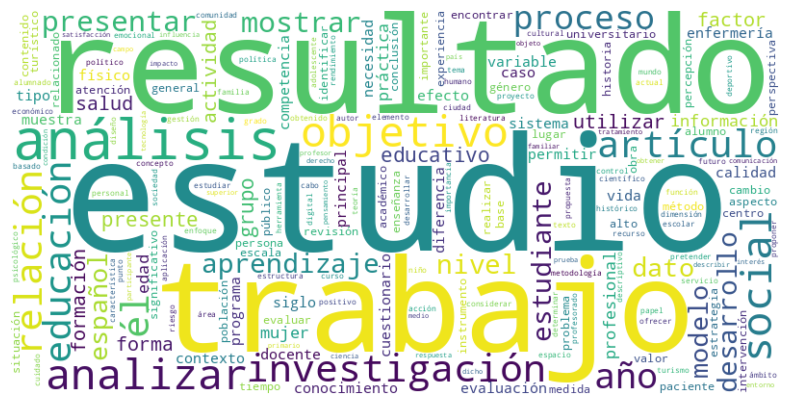


Resumen del análisis del corpus:
--------------------------------
Total de términos procesados: 23454
Total de palabras únicas: 32525
Palabra más frecuente: "estudio" (frecuencia: 11731)
Top 200 palabras más frecuentes:
estudio           11731
resultado          8177
trabajo            7444
análisis           6682
objetivo           5998
social             5855
analizar           5820
investigación      5461
relación           5381
educación          5019
él                 5010
artículo           4920
año                4403
proceso            3944
presentar          3937
mostrar            3883
aprendizaje        3835
nivel              3782
estudiante         3736
desarrollo         3682
dato               3526
español            3504
modelo             3498
educativo          3485
grupo              3439
presente           3401
actividad          3212
utilizar           3096
formación          3059
factor             3003
salud              2997
forma              2909
información

In [ ]:
# Cálculo inicial de palabras más frecuentes de todo el corpus y su frecuencia.


import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime

# Definir rutas de archivos
INPUT_CSV = os.path.join(TABLAS, 'corpus_es.csv')
OUTPUT_WORDCLOUD = os.path.join(GRAFICOS, 'wordcloud_corpus_es.png')
# OUTPUT_TFIDF_CSV = os.path.join(TABLAS, 'tfidf_corpus_es.csv')
SUMMARY_TXT = os.path.join(LOGS, 'tf_idf_corpus_es.txt')

# Iniciar el tiempo de ejecución
start_time = datetime.now()


#"""

# Leer el archivo CSV de entrada
try:
    df = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    print(f"Error: El archivo {INPUT_CSV} no existe.")
    exit()

# Filtrar filas con contenido no nulo
# df_contenido = df[df['Corpus'].notna() & (df['Corpus'] != '')]
df_contenido = df[df['Corpus'].notna() & (df['Corpus'] != '')].copy()

#"""


# Crear el contador
vectorizer = CountVectorizer()

# Entrenar, aplicar y almacenar el recuento de palabras
words_per_comment = vectorizer.fit_transform(df_contenido['Corpus'])
words_per_comment = pd.DataFrame(words_per_comment.toarray(), columns=vectorizer.get_feature_names_out())

# Sumar la frecuencia de cada palabra en todo el corpus
word_counts = words_per_comment.sum()

# Ordenar las palabras por frecuencia
word_counts = word_counts.sort_values(ascending=False)

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Guardar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(OUTPUT_WORDCLOUD)
plt.show()
plt.close()

# Calcular los TF-IDF
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=30000)
tf_idf = vectorizer_tfidf.fit_transform(df_contenido["Corpus"])

df_tfidf = pd.DataFrame(tf_idf.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

# Guardar el DataFrame TF-IDF
# df_tfidf.to_csv(OUTPUT_TFIDF_CSV, index=False)

# ----------------
# EN VEZ DE GUARDAR EL DataFrame TF-IDF, TRABAJAMOS CON EL EN MEMORIA
# PUEDE SUPONER VARIOS GIGAS
# ----------------

# Calcular el tiempo total de ejecución
end_time = datetime.now()
duration = end_time - start_time

# Generar resumen de resultados
resumen = f"""
Resumen del análisis del corpus:
--------------------------------
Total de términos procesados: {len(df_contenido)}
Total de palabras únicas: {len(word_counts)}
Palabra más frecuente: "{word_counts.index[0]}" (frecuencia: {word_counts.iloc[0]})
Top 200 palabras más frecuentes:
{word_counts[:200].to_string()}

Total de características TF-IDF: {df_tfidf.shape[1]}
Tiempo total de ejecución: {duration}

La nube de palabras se ha guardado en:
'{OUTPUT_WORDCLOUD}'


"""

print(resumen)

# Guardar resumen en un archivo TXT
with open(SUMMARY_TXT, 'w', encoding='utf-8') as summary_file:
    summary_file.write(resumen)

print(f"Resumen guardado en '{SUMMARY_TXT}'")


## 5.3 CREACIÓN DE CLUSTER CON SIMILARIDAD DEL COSENO

In [ ]:
# CREACIÓN DE CLUSTER CON SIMILARIDAD DEL COSENO

import os
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

# Definición de rutas de entrada y salida
TABLAS = '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/TABLAS/'
LOGS = '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/LOGS/'
TESAUROS = '/content/drive/MyDrive/4º GICD/TFG/PIPELINE/TESAUROS/'
CORPUS_INPUT = os.path.join(TABLAS, 'corpus_es.csv')
THESAURUS_INPUT = os.path.join(TESAUROS, 'tesauro_unesco_corpus.csv')
CORPUS_OUTPUT = os.path.join(TABLAS, 'clusters.csv')
LOGS_OUTPUT = os.path.join(LOGS, 'creacion_tabla_clusters.txt')

# Definición del umbral de similitud
UMBRAL_SIMILITUD = 0.05

def cargar_datos():
    """Carga los datos del corpus y del tesauro."""
    corpus_df = pd.read_csv(CORPUS_INPUT)
    thesaurus_df = pd.read_csv(THESAURUS_INPUT)
    return corpus_df, thesaurus_df

def calcular_tf_idf(corpus, thesaurus):
    """Calcula los vectores TF-IDF para el corpus y el tesauro."""
    vectorizer = TfidfVectorizer()
    corpus_tfidf = vectorizer.fit_transform(corpus.fillna(''))
    thesaurus_tfidf = vectorizer.transform(thesaurus.fillna(''))
    return corpus_tfidf, thesaurus_tfidf

def calcular_similitud(corpus_tfidf, thesaurus_tfidf):
    """Calcula la similitud del coseno entre el corpus y el tesauro."""
    return cosine_similarity(corpus_tfidf, thesaurus_tfidf)

def asignar_categorias(matriz_similitud, thesaurus_df, top_n=2):
    """
    Asigna categorías a los artículos basándose en la similitud y el umbral.
    Incluye la categoría 'Sin clasificación' si no se supera el umbral.
    """
    categorias = []
    for fila in matriz_similitud:
        if np.max(fila) < UMBRAL_SIMILITUD:
            categorias.append([('Sin clasificación', '0')] * top_n)
        else:
            indices_top = fila.argsort()[-top_n:][::-1]
            cat = [
                (thesaurus_df.iloc[i]['MicroTesauro'], thesaurus_df.iloc[i]['MicroTesauro_ID'])
                for i in indices_top if fila[i] >= UMBRAL_SIMILITUD
            ]
            while len(cat) < top_n:
                cat.append(('Sin clasificación', '0'))
            categorias.append(cat)
    return categorias

def main():
    tiempo_inicio = time.time()

    print("Cargando datos...")
    corpus_df, thesaurus_df = cargar_datos()

    print("Calculando TF-IDF...")
    corpus_tfidf, thesaurus_tfidf = calcular_tf_idf(corpus_df['Corpus'], thesaurus_df['Términos'])

    print("Calculando similitud...")
    matriz_similitud = calcular_similitud(corpus_tfidf, thesaurus_tfidf)

    print("Asignando categorías...")
    categorias = asignar_categorias(matriz_similitud, thesaurus_df)

    # Asignación de categorías al DataFrame del corpus
    corpus_df['Categoria1'] = [cat[0][0] for cat in categorias]


    # corpus_df['Categoria1_ID'] = [cat[0][1] for cat in categorias]
    # RENOMBRAMOS ESTA COLUMNA PARA AJUSTARLA AL PROYECTO
    corpus_df['cluster'] = [cat[0][1] for cat in categorias]


    corpus_df['Categoria2'] = [cat[1][0] if len(cat) > 1 else 'Sin clasificación' for cat in categorias]
    corpus_df['Categoria2_ID'] = [cat[1][1] if len(cat) > 1 else '0' for cat in categorias]

    print("Guardando corpus categorizado...")
    corpus_df.to_csv(CORPUS_OUTPUT, index=False)

    # Generación del resumen
    distribucion_categorias = Counter(corpus_df['Categoria1'])
    total_articulos = len(corpus_df)
    tiempo_ejecucion = time.time() - tiempo_inicio

    resumen = f"""
Resumen de Categorización TF-IDF
--------------------------------
Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos
Total de artículos procesados: {total_articulos}
Umbral de similitud utilizado: {UMBRAL_SIMILITUD}

Distribución de Categorías (Top 10):
{'-' * 40}
"""
    for categoria, conteo in distribucion_categorias.most_common(10):
        porcentaje = (conteo / total_articulos) * 100
        resumen += f"{categoria}: {conteo} ({porcentaje:.2f}%)\n"

    resumen += f"""
{'-' * 40}
Puntuación de similitud promedio: {np.mean(matriz_similitud):.4f}
Puntuación de similitud máxima: {np.max(matriz_similitud):.4f}
Puntuación de similitud mínima: {np.min(matriz_similitud):.4f}

Artículos sin clasificación: {sum(corpus_df['Categoria1'] == 'Sin clasificación')}/{total_articulos} ({(sum(corpus_df['Categoria1'] == 'Sin clasificación') / total_articulos) * 100:.2f}%)
Artículos con múltiples categorías: {sum(corpus_df['Categoria2'] != 'Sin clasificación')}/{total_articulos} ({(sum(corpus_df['Categoria2'] != 'Sin clasificación') / total_articulos) * 100:.2f}%)

Archivos de salida:
- Corpus categorizado: {CORPUS_OUTPUT}
- Este resumen: {LOGS_OUTPUT}
"""

    print(resumen)

    with open(LOGS_OUTPUT, 'w', encoding='utf-8') as f:
        f.write(resumen)

    print(f"Resumen guardado en {LOGS_OUTPUT}")
    print("Cálculo TF-IDF y categorización completados!")

# Ejecutar la función principal
main()


Cargando datos...
Calculando TF-IDF...
Calculando similitud...
Asignando categorías...
Guardando corpus categorizado...

Resumen de Categorización TF-IDF
--------------------------------
Tiempo de ejecución: 7.79 segundos
Total de artículos procesados: 24577
Umbral de similitud utilizado: 0.05

Distribución de Categorías (Top 10):
----------------------------------------
Sin clasificación: 5661 (23.03%)
Literatura: 742 (3.02%)
Historia: 696 (2.83%)
Sistemas sociales: 660 (2.69%)
Sistemas y niveles de enseñanza: 548 (2.23%)
Profesionales de la educación: 497 (2.02%)
Gestión de personal: 494 (2.01%)
Política y gobierno: 463 (1.88%)
Enfoque científico: 456 (1.86%)
Enseñanza y formación: 402 (1.64%)

----------------------------------------
Puntuación de similitud promedio: 0.0119
Puntuación de similitud máxima: 0.9069
Puntuación de similitud mínima: 0.0000

Artículos sin clasificación: 5661/24577 (23.03%)
Artículos con múltiples categorías: 15625/24577 (63.58%)

Archivos de salida:
- Corp

# 6. CREACION DEL FICHERO RDF

In [ ]:
!pip install rdflib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 13.0 MB/s eta 0:00:00


## 6.1 GENERACIÓN DE GRUPOTEMA

---------------------------

MODIFICAR LA GENERACIÓN DE GRUPOTEMA PARA QUE SE GENERE DESDE el TESAURO CORPUS

COMPROBAR SI HAY QUE MODIFICAR LA ONTOLOGÍA Y EL TIPO DE DATO
ES POSIBLE QUE SE PUEDAN AÑADIR EQUIVALENCIAS DE CLASE
Y OTROS DATOS COMO LA URI DEL TESAURO, CATEGORÍA A LA QUE PERTENECE, ETC


In [ ]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import SKOS, DCTERMS, FOAF, RDF, RDFS, XSD, OWL
from tqdm import tqdm
import time

# --------------------------------------------------
# 1. CONFIGURACIÓN INICIAL
# --------------------------------------------------

# a. Definir Rutas de Archivos
PIPELINE = "/content/drive/MyDrive/4º GICD/TFG/PIPELINE/"
TESAUROS = PIPELINE + "TESAUROS/"
LOGS = PIPELINE + "LOGS/"
RDFOUT = PIPELINE + "RDFOUT/"  # Directorio de salida para RDF

# b. Definir Espacios de Nombres (prefijos)
ontorevistas = Namespace("http://gicd.inf.um.es/wd/ontorevistas/")
schema = Namespace("http://schema.org/")
owl = Namespace("http://www.w3.org/2002/07/owl#")
xsd = Namespace("http://www3.org/2001/XMLSchema#")
skos = Namespace("http://www.w3.org/2004/02/skos/core#")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")
foaf = Namespace("http://xmlns.com/foaf/0.1/")
rdf = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
datarevistas = Namespace("http://gicd.inf.um.es/wd/datarevistas/")
dcterms = Namespace("http://purl.org/dc/terms/")
bibo = Namespace("http://purl.org/ontology/bibo/")

# c. Crear un grafo RDF
g = Graph()

# d. Enlazar los espacios de nombres al grafo (para usar los prefijos)
g.bind("ontorevistas", ontorevistas)
g.bind("schema", schema)
g.bind("owl", owl)
g.bind("xsd", xsd)
g.bind("skos", skos)
g.bind("rdfs", rdfs)
g.bind("foaf", foaf)
g.bind("rdf", rdf)
g.bind("datarevistas", datarevistas)
g.bind("dcterms", dcterms)
g.bind("bibo", bibo)

# --------------------------------------------------
# 2. CARGAR DATOS CSV
# --------------------------------------------------

# a. Cargar las tablas CSV usando pandas
try:
    temas_df = pd.read_csv(TESAUROS + "tesauro_unesco_corpus.csv", on_bad_lines='skip', engine='python')
except FileNotFoundError:
    print(f"Error: No se encontró el archivo 'tesauro_unesco_corpus.csv' en la ruta: {TESAUROS}")
    exit()  # Salir del script si no se encuentra el archivo

# --------------------------------------------------
# 3. GENERAR INSTANCIAS DE GRUPOTEMA
# --------------------------------------------------

def generar_grupos_tematicos():
    print("Generando instancias de GrupoTema...")
    for index, row in tqdm(temas_df.iterrows(), total=len(temas_df), desc="Grupos Temáticos"):
        # Crear URI para el grupo temático
        cluster_id = str(row['MicroTesauro_ID']).replace(" ", "")  # Eliminar espacios del ID y convertir a string
        grupo_tema_uri = URIRef(datarevistas[f"tema_{cluster_id}"])

        # Añadir tipos y propiedades
        g.add((grupo_tema_uri, RDF.type, ontorevistas.GrupoTema))
        g.add((grupo_tema_uri, ontorevistas.grupoTemaID, Literal(cluster_id, datatype=XSD.string)))
        g.add((grupo_tema_uri, DCTERMS.title, Literal(row['MicroTesauro'], datatype=XSD.string)))
        g.add((grupo_tema_uri, ontorevistas.grupoTemaArea, Literal(row['Grupo'], datatype=XSD.string)))
        g.add((grupo_tema_uri, RDFS.label, Literal(row['MicroTesauro'], datatype=XSD.string)))
        g.add((grupo_tema_uri, OWL.sameAs, URIRef(row['MicroTesauro_URI'])))

# --------------------------------------------------
# 4. GUARDAR EL GRAFO RDF
# --------------------------------------------------

# a. Iniciar el contador de tiempo
start_time = time.time()
generar_grupos_tematicos()

# b. Calcular el tiempo de ejecución
end_time = time.time()
elapsed_time = end_time - start_time

# Serializar el grafo a Turtle
rdf_output_path = RDFOUT + "grupos_tematicos.ttl"  # Archivo de salida específico
g.serialize(destination=rdf_output_path, format="turtle")

# --------------------------------------------------
# 5. GENERAR REPORTE DE RESULTADOS
# --------------------------------------------------

# Contar tripletas, clases, etc.
num_triples = len(g)
classes = set()
for s, p, o in g:
    if p == RDF.type:
        classes.add(o)

num_classes = len(classes)

# c. Crear reporte
report = f"""
Reporte de Generación de RDF para Grupos Temáticos:
------------------------------
Tiempo de ejecución: {elapsed_time:.2f} segundos
Número de tripletas generadas: {num_triples}
Número de clases utilizadas: {num_classes}
Archivo RDF generado: {rdf_output_path}
"""

print(report)

# d. Guardar el reporte en un archivo de texto
report_path = LOGS + "rdf_grupos_tematicos.txt"
with open(report_path, "w") as f:
    f.write(report)

print("¡Proceso completado para Grupos Temáticos!")


Generando instancias de GrupoTema...


Grupos Temáticos: 100%|██████████| 88/88 [00:00<00:00, 5284.47it/s]



Reporte de Generación de RDF para Grupos Temáticos:
------------------------------
Tiempo de ejecución: 0.02 segundos
Número de tripletas generadas: 528
Número de clases utilizadas: 1
Archivo RDF generado: /content/drive/MyDrive/4º GICD/TFG/PIPELINE/RDFOUT/grupos_tematicos.ttl

¡Proceso completado para Grupos Temáticos!


## 6.2 GENERACIÓN DE REVISTA

In [ ]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import SKOS, DCTERMS, FOAF, RDF, RDFS, XSD
from tqdm import tqdm
import time
import logging

# --------------------------------------------------
# 1. CONFIGURACIÓN INICIAL
# --------------------------------------------------

# a. Definir Rutas de Archivos
PIPELINE = "/content/drive/MyDrive/4º GICD/TFG/PIPELINE/"
TABLAS = PIPELINE + "TABLAS/"
LOGS = PIPELINE + "LOGS/"
RDFOUT = PIPELINE + "RDFOUT/"  # Directorio de salida para RDF

# b. Definir Espacios de Nombres (prefijos)
ontorevistas = Namespace("http://gicd.inf.um.es/wd/ontorevistas/")
schema = Namespace("http://schema.org/")
owl = Namespace("http://www.w3.org/2002/07/owl#")
xsd = Namespace("http://www.w3.org/2001/XMLSchema#")
skos = Namespace("http://www.w3.org/2004/02/skos/core#")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")
foaf = Namespace("http://xmlns.com/foaf/0.1/")
rdf = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
datarevistas = Namespace("http://gicd.inf.um.es/wd/datarevistas/")
dcterms = Namespace("http://purl.org/dc/terms/")
bibo = Namespace("http://purl.org/ontology/bibo/")

# c. Crear un grafo RDF
g = Graph()

# d. Enlazar los espacios de nombres al grafo (para usar los prefijos)
g.bind("ontorevistas", ontorevistas)
g.bind("schema", schema)
g.bind("owl", owl)
g.bind("xsd", xsd)
g.bind("skos", skos)
g.bind("rdfs", rdfs)
g.bind("foaf", foaf)
g.bind("rdf", RDF)
g.bind("datarevistas", datarevistas)
g.bind("dcterms", dcterms)
g.bind("bibo", bibo)

# --------------------------------------------------
# 2. CARGAR DATOS CSV
# --------------------------------------------------

# a. Cargar las tablas CSV usando pandas
try:
    revistas_df = pd.read_csv(TABLAS + "revistas.csv")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo 'revistas.csv' en la ruta: {TABLAS}")
    exit()  # Salir del script si no se encuentra el archivo

# --------------------------------------------------
# 3. GENERAR INSTANCIAS DE REVISTA
# --------------------------------------------------

def generar_revistas():
    print("Generando instancias de Revista...")
    for index, row in tqdm(revistas_df.iterrows(), total=len(revistas_df), desc="Revistas"):
        # Crear URI para la revista
        revista_id = row['Revista_ID'].replace(" ", "")
        revista_uri = URIRef(datarevistas[f"revista_{revista_id}"])

        # Añadir tipos y propiedades
        g.add((revista_uri, RDF.type, ontorevistas.Revista))
        g.add((revista_uri, DCTERMS.identifier, Literal(revista_id, datatype=XSD.string)))
        g.add((revista_uri, RDFS.label, Literal(row['Nombre'], datatype=XSD.string)))
        g.add((revista_uri, ontorevistas.revistaURL, URIRef(row['URL'])))
        g.add((revista_uri, ontorevistas.revistaImagen, URIRef(row['Imagen']))) #Añadimos la imagen

        # Properties
        if pd.notna(row['DOI']):
            g.add((revista_uri, ontorevistas.revistaDOI, URIRef(row['DOI'])))
        if pd.notna(row['ISSN-E']):
            g.add((revista_uri, ontorevistas.revistaISSNE, Literal(row['ISSN-E'], datatype=XSD.string)))
        if pd.notna(row['ISSN-Impreso']):
            g.add((revista_uri, ontorevistas.revistaISSN, Literal(row['ISSN-Impreso'], datatype=XSD.string)))

# --------------------------------------------------
# 4. GUARDAR EL GRAFO RDF
# --------------------------------------------------

# a. Iniciar el contador de tiempo
start_time = time.time()
generar_revistas()

# b. Calcular el tiempo de ejecución
end_time = time.time()
elapsed_time = end_time - start_time

# Serializar el grafo a Turtle
rdf_output_path = RDFOUT + "revistas.ttl"  # Archivo de salida específico
g.serialize(destination=rdf_output_path, format="turtle")


# --------------------------------------------------
# 5. GENERAR REPORTE DE RESULTADOS
# --------------------------------------------------

# Contar tripletas, clases, etc.
num_triples = len(g)
classes = set()
for s, p, o in g:
    if p == RDF.type:
        classes.add(o)

num_classes = len(classes)

# c. Crear reporte
report = f"""
Reporte de Generación de RDF para Revistas:
------------------------------
Tiempo de ejecución: {elapsed_time:.2f} segundos
Número de tripletas generadas: {num_triples}
Número de clases utilizadas: {num_classes}
Archivo RDF generado: {rdf_output_path}
"""

print(report)

# d. Guardar el reporte en un archivo de texto
report_path = LOGS + "rdf_revistas.txt"
with open(report_path, "w") as f:
    f.write(report)

print("¡Proceso completado para Revistas!")


Generando instancias de Revista...


Revistas: 100%|██████████| 43/43 [00:00<00:00, 3125.63it/s]


Reporte de Generación de RDF para Revistas:
------------------------------
Tiempo de ejecución: 0.02 segundos
Número de tripletas generadas: 323
Número de clases utilizadas: 1
Archivo RDF generado: /content/drive/MyDrive/4º GICD/TFG/PIPELINE/RDFOUT/revistas.ttl



¡Proceso completado para Revistas!


## 6.3 GENERACION DE NUMEROS

In [ ]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import SKOS, DCTERMS, FOAF, RDF, RDFS, XSD
from tqdm import tqdm
import time
import re

# --------------------------------------------------
# 1. CONFIGURACIÓN INICIAL
# --------------------------------------------------

# a. Definir Rutas de Archivos
PIPELINE = "/content/drive/MyDrive/4º GICD/TFG/PIPELINE/"
TABLAS = PIPELINE + "TABLAS/"
LOGS = PIPELINE + "LOGS/"
RDFOUT = PIPELINE + "RDFOUT/"  # Directorio de salida para RDF

# b. Definir Espacios de Nombres (prefijos)
ontorevistas = Namespace("http://gicd.inf.um.es/wd/ontorevistas/")
schema = Namespace("http://schema.org/")
owl = Namespace("http://www.w3.org/2002/07/owl#")
xsd = Namespace("http://www.w3.org/2001/XMLSchema#")
skos = Namespace("http://www.w3.org/2004/02/skos/core#")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")
foaf = Namespace("http://xmlns.com/foaf/0.1/")
rdf = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
datarevistas = Namespace("http://gicd.inf.um.es/wd/datarevistas/")
dcterms = Namespace("http://purl.org/dc/terms/")
bibo = Namespace("http://purl.org/ontology/bibo/")

# c. Crear un grafo RDF
g = Graph()

# d. Enlazar los espacios de nombres al grafo (para usar los prefijos)
g.bind("ontorevistas", ontorevistas)
g.bind("schema", schema)
g.bind("owl", owl)
g.bind("xsd", xsd)
g.bind("skos", skos)
g.bind("rdfs", rdfs)
g.bind("foaf", foaf)
g.bind("rdf", rdf)
g.bind("datarevistas", datarevistas)
g.bind("dcterms", dcterms)
g.bind("bibo", bibo)

# --------------------------------------------------
# 2. CARGAR DATOS CSV
# --------------------------------------------------

# a. Cargar las tablas CSV usando pandas
try:
    numeros_df = pd.read_csv(TABLAS + "numeros.csv")
    articulos_html_df = pd.read_csv(TABLAS + "articulos_html.csv")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo 'numeros.csv' en la ruta: {TABLAS}")
    exit()  # Salir del script si no se encuentra el archivo

# --------------------------------------------------
# 3. GENERAR INSTANCIAS DE NUMERO
# --------------------------------------------------

def generar_numeros():
    print("Generando instancias de Numero...")
    numero_id_counter = 1  # Inicializar el contador de ID

    for index, row in tqdm(numeros_df.iterrows(), total=len(numeros_df), desc="Números"):
        # Obtener datos de la fila
        revista_id = row['Revista_ID'].replace(" ", "")
        volumen = row['volumen']
        nombre_volumen = row['revista_volumen']

        # Crear URI para el número
        numero_id = f"{numero_id_counter:04d}"  # ID numérico con formato
        numero_uri = URIRef(datarevistas[f"numero_{revista_id}_{numero_id}"])

        #Añadir el tipo al principio
        g.add((numero_uri, RDF.type, ontorevistas.Numero))

        # Obtener la URI de la revista a la que pertenece el número
        revista_uri = URIRef(datarevistas[f"revista_{revista_id}"])

        # Añadir propiedades
        g.add((numero_uri, ontorevistas.numeroVolumen, Literal(volumen, datatype=XSD.string)))
        g.add((numero_uri, ontorevistas.esParteDeRevista, revista_uri))
        g.add((numero_uri, RDFS.label, Literal(f"{nombre_volumen}", datatype=XSD.string)))

        if pd.notna(row['volumen_url']):
            g.add((numero_uri, ontorevistas.numeroURL, URIRef(row['volumen_url'])))

        # Añadir la imagen del número
        if pd.notna(row['imagen_numero']):
            g.add((numero_uri, ontorevistas.numeroImagen, URIRef(row['imagen_numero'])))


        # Añadir artículos al número
        articulos_numero = articulos_html_df[articulos_html_df['revista_volumen'] == nombre_volumen]
        for _, articulo_row in articulos_numero.iterrows():
            ns0_identifier = articulo_row['ns0_identifier']
            articulo_id = re.search(r'article/(\d+)', ns0_identifier).group(1)
            articulo_uri = URIRef(datarevistas[f"articulo_{articulo_id}"])
            g.add((numero_uri, ontorevistas.tieneArticulo, articulo_uri))


        numero_id_counter += 1  # Incrementar el contador para el siguiente número

# --------------------------------------------------
# 4. GUARDAR EL GRAFO RDF
# --------------------------------------------------

# a. Iniciar el contador de tiempo
start_time = time.time()
generar_numeros()

# b. Calcular el tiempo de ejecución
end_time = time.time()
elapsed_time = end_time - start_time

# Serializar el grafo a Turtle
rdf_output_path = RDFOUT + "numeros.ttl"  # Archivo de salida específico
g.serialize(destination=rdf_output_path, format="turtle")

# --------------------------------------------------
# 5. GENERAR REPORTE DE RESULTADOS
# --------------------------------------------------

# Contar tripletas, clases, etc.
num_triples = len(g)
classes = set()
for s, p, o in g:
    if p == RDF.type:
        classes.add(o)

num_classes = len(classes)

# c. Crear reporte
report = f"""
Reporte de Generación de RDF para Números:
------------------------------
Tiempo de ejecución: {elapsed_time:.2f} segundos
Número de tripletas generadas: {num_triples}
Número de clases utilizadas: {num_classes}
Archivo RDF generado: {rdf_output_path}
"""

print(report)

# d. Guardar el reporte en un archivo de texto
report_path = LOGS + "rdf_numeros.txt"
with open(report_path, "w") as f:
    f.write(report)

print("¡Proceso completado para Números!")


Generando instancias de Numero...


Números: 100%|██████████| 1598/1598 [00:08<00:00, 191.30it/s]



Reporte de Generación de RDF para Números:
------------------------------
Tiempo de ejecución: 8.37 segundos
Número de tripletas generadas: 33286
Número de clases utilizadas: 1
Archivo RDF generado: /content/drive/MyDrive/4º GICD/TFG/PIPELINE/RDFOUT/numeros.ttl

¡Proceso completado para Números!


## 6.4 GENERACION DE AUTOR

In [ ]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import SKOS, DCTERMS, FOAF, RDF, RDFS, XSD
from tqdm import tqdm
import time
import logging
import re

# --------------------------------------------------
# 1. CONFIGURACIÓN INICIAL
# --------------------------------------------------

# a. Definir Rutas de Archivos
PIPELINE = "/content/drive/MyDrive/4º GICD/TFG/PIPELINE/"
TABLAS = PIPELINE + "TABLAS/"
LOGS = PIPELINE + "LOGS/"
RDFOUT = PIPELINE + "RDFOUT/"  # Directorio de salida para RDF

# b. Definir Espacios de Nombres (prefijos)
ontorevistas = Namespace("http://gicd.inf.um.es/wd/ontorevistas/")
schema = Namespace("http://schema.org/")
owl = Namespace("http://www.w3.org/2002/07/owl#")
xsd = Namespace("http://www.w3.org/2001/XMLSchema#")
skos = Namespace("http://www.w3.org/2004/02/skos/core#")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")
foaf = Namespace("http://xmlns.com/foaf/0.1/")
rdf = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
datarevistas = Namespace("http://gicd.inf.um.es/wd/datarevistas/")
dcterms = Namespace("http://purl.org/dc/terms/")
bibo = Namespace("http://purl.org/ontology/bibo/")

# c. Crear un grafo RDF
g = Graph()

# d. Enlazar los espacios de nombres al grafo (para usar los prefijos)
g.bind("ontorevistas", ontorevistas)
g.bind("schema", schema)
g.bind("owl", owl)
g.bind("xsd", xsd)
g.bind("skos", skos)
g.bind("rdfs", rdfs)
g.bind("foaf", foaf)
g.bind("rdf", rdf)
g.bind("datarevistas", datarevistas)
g.bind("dcterms", dcterms)
g.bind("bibo", bibo)

# --------------------------------------------------
# 2. CARGAR DATOS CSV
# --------------------------------------------------

# a. Cargar las tablas CSV usando pandas
try:
    autores_df = pd.read_csv(TABLAS + "autores_normalizados.csv")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo 'autores_normalizados.csv' en la ruta: {TABLAS}")
    exit()  # Salir del script si no se encuentra el archivo

# --------------------------------------------------
# 3. GENERAR INSTANCIAS DE AUTOR
# --------------------------------------------------

def generar_autores():
    print("Generando instancias de Autor...")
    for index, row in tqdm(autores_df.iterrows(), total=len(autores_df), desc="Autores"):
        # Crear URI para el autor
        autor_id = f"AU-UM-01{index+1:06d}"
        autor_uri = URIRef(datarevistas[f"autor_{autor_id}"])

        # Añadir tipos y propiedades
        g.add((autor_uri, RDF.type, ontorevistas.Autor))
        g.add((autor_uri, ontorevistas.autorID, Literal(autor_id, datatype=XSD.string)))
        g.add((autor_uri, RDFS.label, Literal(row['author'], datatype=XSD.string)))

        # Añadir relación con artículos
        if pd.notna(row['ns0_identifiers']):
            articulos = row['ns0_identifiers'].split(" | ")
            for articulo in articulos:
                articulo_id = re.search(r'article/(\d+)', articulo)
                if articulo_id:
                    articulo_uri = URIRef(datarevistas[f"articulo_{articulo_id.group(1)}"])
                    g.add((autor_uri, ontorevistas.esAutorDe, articulo_uri))

# --------------------------------------------------
# 4. GUARDAR EL GRAFO RDF
# --------------------------------------------------

# a. Iniciar el contador de tiempo
start_time = time.time()
generar_autores()

# b. Calcular el tiempo de ejecución
end_time = time.time()
elapsed_time = end_time - start_time

# Serializar el grafo a Turtle
rdf_output_path = RDFOUT + "autores.ttl"  # Archivo de salida específico
g.serialize(destination=rdf_output_path, format="turtle")

# --------------------------------------------------
# 5. GENERAR REPORTE DE RESULTADOS
# --------------------------------------------------

# Contar tripletas, clases, etc.
num_triples = len(g)
classes = set()
for s, p, o in g:
    if p == RDF.type:
        classes.add(o)

num_classes = len(classes)

# c. Crear reporte
report = f"""
Reporte de Generación de RDF para Autores:
------------------------------
Tiempo de ejecución: {elapsed_time:.2f} segundos
Número de tripletas generadas: {num_triples}
Número de clases utilizadas: {num_classes}
Archivo RDF generado: {rdf_output_path}
"""

print(report)

# d. Guardar el reporte en un archivo de texto
report_path = LOGS + "rdf_autores.txt"
with open(report_path, "w") as f:
    f.write(report)

print("¡Proceso completado para Autores!")


Generando instancias de Autor...


Autores: 100%|██████████| 33049/33049 [00:06<00:00, 5125.15it/s]



Reporte de Generación de RDF para Autores:
------------------------------
Tiempo de ejecución: 6.46 segundos
Número de tripletas generadas: 147937
Número de clases utilizadas: 1
Archivo RDF generado: /content/drive/MyDrive/4º GICD/TFG/PIPELINE/RDFOUT/autores.ttl

¡Proceso completado para Autores!


## 6.5 GENERACION DE PALABRAS CLAVE

In [ ]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import SKOS, DCTERMS, FOAF, RDF, RDFS, XSD
from tqdm import tqdm
import time
import logging
import re

# --------------------------------------------------
# 1. CONFIGURACIÓN INICIAL
# --------------------------------------------------

# a. Definir Rutas de Archivos
PIPELINE = "/content/drive/MyDrive/4º GICD/TFG/PIPELINE/"
TABLAS = PIPELINE + "TABLAS/"
LOGS = PIPELINE + "LOGS/"
RDFOUT = PIPELINE + "RDFOUT/"  # Directorio de salida para RDF

# b. Definir Espacios de Nombres (prefijos)
ontorevistas = Namespace("http://gicd.inf.um.es/wd/ontorevistas/")
schema = Namespace("http://schema.org/")
owl = Namespace("http://www.w3.org/2002/07/owl#")
xsd = Namespace("http://www.w3.org/2001/XMLSchema#")
skos = Namespace("http://www.w3.org/2004/02/skos/core#")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")
foaf = Namespace("http://xmlns.com/foaf/0.1/")
rdf = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
datarevistas = Namespace("http://gicd.inf.um.es/wd/datarevistas/")
dcterms = Namespace("http://purl.org/dc/terms/")
bibo = Namespace("http://purl.org/ontology/bibo/")

# c. Crear un grafo RDF
g = Graph()

# d. Enlazar los espacios de nombres al grafo (para usar los prefijos)
g.bind("ontorevistas", ontorevistas)
g.bind("schema", schema)
g.bind("owl", owl)
g.bind("xsd", xsd)
g.bind("skos", skos)
g.bind("rdfs", rdfs)
g.bind("foaf", foaf)
g.bind("rdf", rdf)
g.bind("datarevistas", datarevistas)
g.bind("dcterms", dcterms)
g.bind("bibo", bibo)

# --------------------------------------------------
# 2. CARGAR DATOS CSV
# --------------------------------------------------

# a. Cargar las tablas CSV usando pandas
try:
    keywords_df = pd.read_csv(TABLAS + "keywords_es.csv")
    keywords_unesco_df = pd.read_csv(TABLAS + "keywords_unesco.csv")
    keywords_lem_df = pd.read_csv(TABLAS + "keywords_lem.csv")
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo: {e.filename}")
    exit()

# --------------------------------------------------
# 3. GENERAR INSTANCIAS DE PALABRACLAVE
# --------------------------------------------------

def generar_palabras_clave():
    print("Generando instancias de PalabraClave...")
    instancias_generadas = 0
    enriquecidas_lem = 0
    enriquecidas_unesco = 0
    enriquecidas_ambas = 0
    keyword_counter = 1

    for index, row in tqdm(keywords_df.iterrows(), total=len(keywords_df), desc="Palabras Clave"):
        # Crear URI para la palabra clave
        keyword = row['keyword']
        keyword_id = f"KW-UM-01{keyword_counter:06d}"
        keyword_uri = URIRef(datarevistas[f"palabraclave_{keyword_id}"])

        # Añadir tipos y propiedades
        g.add((keyword_uri, RDF.type, ontorevistas.PalabraClave))
        g.add((keyword_uri, RDFS.label, Literal(keyword, datatype=XSD.string)))

        # Añadir relación con artículos
        if pd.notna(row['ns0_identifiers']):
            articulos = row['ns0_identifiers'].split(" | ")
            for articulo in articulos:
                articulo_id = re.search(r'article/(\d+)', articulo)
                if articulo_id:
                    articulo_uri = URIRef(datarevistas[f"articulo_{articulo_id.group(1)}"])
                    g.add((keyword_uri, ontorevistas.esPalabraClaveDe, articulo_uri))

        # Añadir términos UNESCO si existen
        unesco_terms = keywords_unesco_df[keywords_unesco_df['keyword'] == keyword]['unesco_URI'].tolist()
        for term in unesco_terms:
            g.add((keyword_uri, ontorevistas.terminoUnesco, URIRef(term)))

        # Añadir términos LEM si existen
        lem_terms = keywords_lem_df[keywords_lem_df['keyword'] == keyword]['lem_URI'].tolist()
        for term in lem_terms:
            g.add((keyword_uri, ontorevistas.terminoLEM, URIRef(term)))

        instancias_generadas += 1
        if unesco_terms:
            enriquecidas_unesco += 1
        if lem_terms:
            enriquecidas_lem += 1
        if unesco_terms and lem_terms:
            enriquecidas_ambas += 1

        keyword_counter += 1

    return instancias_generadas, enriquecidas_lem, enriquecidas_unesco, enriquecidas_ambas

# --------------------------------------------------
# 4. GUARDAR EL GRAFO RDF
# --------------------------------------------------

# a. Iniciar el contador de tiempo
start_time = time.time()
instancias_generadas, enriquecidas_lem, enriquecidas_unesco, enriquecidas_ambas = generar_palabras_clave()
end_time = time.time()
elapsed_time = end_time - start_time

# Serializar el grafo a Turtle
rdf_output_path = RDFOUT + "palabras_clave.ttl"
g.serialize(destination=rdf_output_path, format="turtle")

# --------------------------------------------------
# 5. GENERAR REPORTE DE RESULTADOS
# --------------------------------------------------

# Contar tripletas, clases, etc.
num_triples = len(g)
classes = set()
for s, p, o in g:
    if p == RDF.type:
        classes.add(o)

num_classes = len(classes)

# c. Crear reporte
report = f"""
Reporte de Generación de RDF para Palabras Clave:
------------------------------
Tiempo de ejecución: {elapsed_time:.2f} segundos
Número de tripletas generadas: {num_triples}
Número de clases utilizadas: {num_classes}
Archivo RDF generado: {rdf_output_path}

Resumen de instancias:
------------------------------
Total de instancias generadas: {instancias_generadas}
Instancias enriquecidas con LEM: {enriquecidas_lem}
Instancias enriquecidas con UNESCO: {enriquecidas_unesco}
Instancias enriquecidas con ambas: {enriquecidas_ambas}
"""

print(report)

# d. Guardar el reporte en un archivo de texto
report_path = LOGS + "rdf_palabras_clave.txt"
with open(report_path, "w") as f:
    f.write(report)

print("¡Proceso completado para Palabras Clave!")


Generando instancias de PalabraClave...


Palabras Clave: 100%|██████████| 39719/39719 [00:59<00:00, 667.72it/s]



Reporte de Generación de RDF para Palabras Clave:
------------------------------
Tiempo de ejecución: 59.49 segundos
Número de tripletas generadas: 163254
Número de clases utilizadas: 1
Archivo RDF generado: /content/drive/MyDrive/4º GICD/TFG/PIPELINE/RDFOUT/palabras_clave.ttl

Resumen de instancias:
------------------------------
Total de instancias generadas: 39719
Instancias enriquecidas con LEM: 2804
Instancias enriquecidas con UNESCO: 1764
Instancias enriquecidas con ambas: 723

¡Proceso completado para Palabras Clave!


## 6.6. GENERACION DE ARTICULOS

modificar la propiedad ontorevistas:numeroFechaPublicacion


ontorevistas:articuloFechaPublicacion a owl:DatatypeProperty;

  rdfs:label "Fecha de publicación del artículo"@es;

  rdfs:range xsd:date;

  rdfs:domain ontorevistas:Articulo;

  rdfs:subPropertyOf dcterms:date .

In [ ]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import SKOS, DCTERMS, FOAF, RDF, RDFS, XSD
from tqdm import tqdm
import time
import logging
import re

# --------------------------------------------------
# 1. CONFIGURACIÓN INICIAL
# --------------------------------------------------


# a. Definir Rutas de Archivos
PIPELINE = "/content/drive/MyDrive/4º GICD/TFG/PIPELINE/"
TABLAS = PIPELINE + "TABLAS/"
LOGS = PIPELINE + "LOGS/"
RDFOUT = PIPELINE + "RDFOUT/"  # Directorio de salida para RDF

# b. Definir Espacios de Nombres (prefijos)
ontorevistas = Namespace("http://gicd.inf.um.es/wd/ontorevistas/")
schema = Namespace("http://schema.org/")
owl = Namespace("http://www.w3.org/2002/07/owl#")
xsd = Namespace("http://www.w3.org/2001/XMLSchema#")
skos = Namespace("http://www.w3.org/2004/02/skos/core#")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")
foaf = Namespace("http://xmlns.com/foaf/0.1/")
rdf = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
datarevistas = Namespace("http://gicd.inf.um.es/wd/datarevistas/")
dcterms = Namespace("http://purl.org/dc/terms/")
bibo = Namespace("http://purl.org/ontology/bibo/")

# c. Crear un grafo RDF
g = Graph()

# d. Enlazar los espacios de nombres al grafo (para usar los prefijos)
g.bind("ontorevistas", ontorevistas)
g.bind("schema", schema)
g.bind("owl", owl)
g.bind("xsd", xsd)
g.bind("skos", skos)
g.bind("rdfs", rdfs)
g.bind("foaf", foaf)
g.bind("rdf", RDF)
g.bind("datarevistas", datarevistas)
g.bind("dcterms", dcterms)
g.bind("bibo", bibo)

# --------------------------------------------------
# 2. CARGAR DATOS CSV
# --------------------------------------------------

try:
    articulos_df = pd.read_csv(TABLAS + "articulos.csv")
    articulos_html_df = pd.read_csv(TABLAS + "articulos_html.csv")
    corpus_es_df = pd.read_csv(TABLAS + "corpus_es.csv")
    clusters_df = pd.read_csv(TABLAS + "clusters.csv")
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo: {e.filename}")
    exit()

# --------------------------------------------------
# 3. GENERAR INSTANCIAS DE ARTICULO
# --------------------------------------------------

def generar_articulos():
    print("Generando instancias de Articulo...")
    instancias_generadas = 0

    for index, row in tqdm(articulos_df.iterrows(), total=min(100, len(articulos_df)), desc="Artículos"):
        ns0_identifier = row['ns0_identifier']
        articulo_id = re.search(r'article/(\d+)', ns0_identifier).group(1)
        articulo_uri = URIRef(datarevistas[f"articulo_{articulo_id}"])

        g.add((articulo_uri, RDF.type, ontorevistas.Articulo))

        if pd.notna(row['title']):
            g.add((articulo_uri, RDFS.label, Literal(row['title'], datatype=XSD.string)))

        g.add((articulo_uri, ontorevistas.articuloOAI, URIRef(ns0_identifier)))

        if pd.notna(row['description']):
            g.add((articulo_uri, ontorevistas.articuloResumen, Literal(row['description'], datatype=XSD.string)))

        if pd.notna(row['publisher']):
            g.add((articulo_uri, ontorevistas.articuloEditor, Literal(row['publisher'], datatype=XSD.string)))

        if pd.notna(row['language']):
            g.add((articulo_uri, ontorevistas.articuloIdioma, Literal(row['language'], datatype=XSD.string)))

     #   if pd.notna(row['identifier']):
     #       identificadores = row['identifier'].split(" | ")
     #       for identificador in identificadores:
     #           g.add((articulo_uri, ontorevistas.articuloURL, URIRef(identificador.strip())))

     #   identificador = articulos_html_df[articulos_html_df['ns0_identifier'] == ns0_identifier]['identifier'].values
     #   if len(identificador) > 0 and pd.notna(identificador[0]):
     #       g.add((articulo_uri, ontorevistas.articuloURL, URIRef(identificador)))

     #   artdoi = articulos_html_df[articulos_html_df['ns0_identifier'] == ns0_identifier]['doi'].values
     #   if len(artdoi) > 0 and pd.notna(artdoi[0]):
     #       g.add((articulo_uri, ontorevistas.articuloDOI, URIRef(artdoi)))

        # URLs únicas desde articulos_html.csv
        html_data = articulos_html_df[articulos_html_df['ns0_identifier'] == ns0_identifier]
        if not html_data.empty:
            # Procesar URLs únicas
            if pd.notna(html_data['identifier'].values[0]):
                url = html_data['identifier'].values[0].strip()  # Solo una URL sin duplicados
                g.add((articulo_uri, ontorevistas.articuloURL, URIRef(url)))

            # Añadir DOI si existe
            doi_value = html_data['doi'].values[0]
            if pd.notna(doi_value):
                g.add((articulo_uri, ontorevistas.articuloDOI, URIRef(doi_value)))  # Cambiado a URIRef


        if pd.notna(row['relation']):
            relaciones = row['relation'].split(" | ")
            for relacion in relaciones:
                g.add((articulo_uri, ontorevistas.articuloRecursoURI, URIRef(relacion.strip())))

        if pd.notna(row['date']):
            g.add((articulo_uri, ontorevistas.articuloFechaPublicacion, Literal(row['date'], datatype=XSD.date)))

        cita = articulos_html_df[articulos_html_df['ns0_identifier'] == ns0_identifier]['cita'].values
        if len(cita) > 0 and pd.notna(cita[0]):
            g.add((articulo_uri, ontorevistas.articuloCita, Literal(cita[0], datatype=XSD.string)))

        #palabras_nlp = corpus_es_df[corpus_es_df['ns_identifier'] == ns0_identifier]['Corpus'].values
        #if len(palabras_nlp) > 0 and pd.notna(palabras_nlp[0]):
        #    g.add((articulo_uri, ontorevistas.articuloPalabrasNLP, Literal(palabras_nlp[0], datatype=XSD.string)))

        cluster = clusters_df[clusters_df['ns_identifier'] == ns0_identifier]['cluster'].values
        if len(cluster) > 0 and pd.notna(cluster[0]):
            grupo_tema_uri = URIRef(datarevistas[f"tema_{str(cluster[0])}"])
            g.add((articulo_uri, ontorevistas.perteneceAGrupoTema, grupo_tema_uri))

        instancias_generadas += 1

    return instancias_generadas

# --------------------------------------------------
# 4. GUARDAR EL GRAFO RDF
# --------------------------------------------------

start_time = time.time()
instancias_generadas = generar_articulos()
end_time = time.time()
elapsed_time = end_time - start_time

rdf_output_path = RDFOUT + "articulos.ttl"
g.serialize(destination=rdf_output_path, format="turtle")

# --------------------------------------------------
# 5. GENERAR REPORTE DE RESULTADOS
# --------------------------------------------------

num_triples = len(g)
classes = set()
for s, p, o in g:
    if p == RDF.type:
        classes.add(o)

num_classes = len(classes)

report = f"""
Reporte de Generación de RDF para Artículos:
------------------------------
Tiempo de ejecución: {elapsed_time:.2f} segundos
Número de tripletas generadas: {num_triples}
Número de clases utilizadas: {num_classes}
Archivo RDF generado: {rdf_output_path}

Resumen de instancias:
------------------------------
Total de instancias generadas: {instancias_generadas}
"""

print(report)

report_path = LOGS + "rdf_articulos.txt"
with open(report_path, "w") as f:
    f.write(report)

print("¡Proceso completado para Artículos!")


Generando instancias de Articulo...


Artículos: 24577it [04:04, 100.40it/s]



Reporte de Generación de RDF para Artículos:
------------------------------
Tiempo de ejecución: 244.80 segundos
Número de tripletas generadas: 281359
Número de clases utilizadas: 1
Archivo RDF generado: /content/drive/MyDrive/4º GICD/TFG/PIPELINE/RDFOUT/articulos.ttl

Resumen de instancias:
------------------------------
Total de instancias generadas: 24577

¡Proceso completado para Artículos!


## 6.7 CREACION DEL FICHERO TTL UNIFICADO

In [ ]:
import rdflib
from rdflib import Graph, Namespace, Literal
from rdflib.namespace import RDF, DCTERMS, XSD, DCAT
import os
import time

# Variables para la autoría y metadatos del dataset
DATASET_TITLE = "Dataset de Revistas Científicas de la Universidad de Murcia"
DATASET_DESCRIPTION = "Dataset creado a partir de los metadatos OAI-PMH publicados en el repositorio de la Universidad de Murcia que contiene información sobre revistas científicas, números, artículos, autores, palabras clave y grupos temáticos."
DATASET_AUTHOR = "Pedro Otálora"
DATASET_LICENSE = "http://creativecommons.org/licenses/by/4.0/"
DATASET_CREATED = "2025-03-08"
DATASET_LANGUAGE = "es"
DATASET_PUBLISHER = "Universidad de Murcia"
DATASET_SUBJECT = "Revistas científicas"

# Configuración de rutas
PIPELINE = "/content/drive/MyDrive/4º GICD/TFG/PIPELINE/"
RDFOUT = PIPELINE + "RDFOUT/"
LOGS = PIPELINE + "LOGS/"

# Definir espacios de nombres
ontorevistas = Namespace("http://gicd.inf.um.es/wd/ontorevistas/")
datarevistas = Namespace("http://gicd.inf.um.es/wd/datarevistas/")

# Crear un nuevo grafo
g = Graph()

# Cargar los 6 archivos TTL
ttl_files = ['revistas.ttl', 'numeros.ttl', 'articulos.ttl', 'autores.ttl', 'palabras_clave.ttl', 'grupos_tematicos.ttl']

for file in ttl_files:
    g.parse(RDFOUT + file, format='turtle')

# Establecer relaciones inversas y preservar originales
inverse_relations = [
    (ontorevistas.tieneNumero, ontorevistas.esParteDeRevista),
    (ontorevistas.tieneArticulo, ontorevistas.esParteDeNumero),
    (ontorevistas.tieneAutor, ontorevistas.esAutorDe),
    (ontorevistas.tienePalabraClave, ontorevistas.esPalabraClaveDe),
    (ontorevistas.perteneceAGrupoTema, ontorevistas.esGrupoTemaDe)
]

for rel, inv_rel in inverse_relations:
    for s, o in g.subject_objects(rel):
        # Preservar la relación original y añadir la inversa
        g.add((s, rel, o))
        g.add((o, inv_rel, s))

# Generar relaciones directas a partir de las inversas si no están presentes
inverse_to_direct_relations = {
    ontorevistas.esAutorDe: ontorevistas.tieneAutor,
    ontorevistas.esParteDeRevista: ontorevistas.tieneNumero,
    ontorevistas.esParteDeNumero: ontorevistas.tieneArticulo,
    ontorevistas.esPalabraClaveDe: ontorevistas.tienePalabraClave,
    ontorevistas.esGrupoTemaDe: ontorevistas.perteneceAGrupoTema
}

for inverse_rel, direct_rel in inverse_to_direct_relations.items():
    for s, p, o in g.triples((None, inverse_rel, None)):
        if not (o, direct_rel, s) in g:
            g.add((o, direct_rel, s))

# Añadir metadatos del dataset
dataset_uri = rdflib.URIRef("http://gicd.inf.um.es/wd/datarevistas/revistas-cientificas")
g.add((dataset_uri, RDF.type, DCAT.Dataset))
g.add((dataset_uri, DCTERMS.title, Literal(DATASET_TITLE, lang="es")))
g.add((dataset_uri, DCTERMS.description, Literal(DATASET_DESCRIPTION, lang="es")))
g.add((dataset_uri, DCTERMS.creator, Literal(DATASET_AUTHOR)))
g.add((dataset_uri, DCTERMS.license, rdflib.URIRef(DATASET_LICENSE)))
g.add((dataset_uri, DCTERMS.created, Literal(DATASET_CREATED, datatype=XSD.date)))
g.add((dataset_uri, DCTERMS.language, Literal(DATASET_LANGUAGE)))
g.add((dataset_uri, DCTERMS.publisher, Literal(DATASET_PUBLISHER)))
g.add((dataset_uri, DCTERMS.subject, Literal(DATASET_SUBJECT)))

# Guardar el grafo unificado
start_time = time.time()
unified_ttl_path = RDFOUT + "dataset_unificado.ttl"
g.serialize(destination=unified_ttl_path, format="turtle")
end_time = time.time()

# Generar reporte
num_triples = len(g)
classes = set(g.subjects(predicate=RDF.type))
num_classes = len(classes)

report = f"""
Reporte de Unificación de RDF:
------------------------------
Tiempo de ejecución: {end_time - start_time:.2f} segundos
Número de tripletas generadas: {num_triples}
Número de clases: {num_classes}
Archivo RDF unificado generado: {unified_ttl_path}
"""

print(report)

# Guardar el reporte
report_path = LOGS + "rdf_dataset_unificado.txt"
with open(report_path, "w") as f:
    f.write(report)

print("¡Proceso de unificación completado!")



Reporte de Unificación de RDF:
------------------------------
Tiempo de ejecución: 62.48 segundos
Número de tripletas generadas: 805270
Número de clases: 99076
Archivo RDF unificado generado: /content/drive/MyDrive/4º GICD/TFG/PIPELINE/RDFOUT/dataset_unificado.ttl

¡Proceso de unificación completado!
